# Similarity And Performance Analysis For Left Wingers
## This notebook rebuilds the Edvin Austbø similarity model for left wingers across Europe’s top leagues, adds visual explanations of the weighting structure, and blends stylistic fit with league-adjusted performance outputs.


In [ ]:
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', None)

# --- 1. Sett opp relative paths ---
BASE_DIR = Path().resolve()
RAW_DIR = BASE_DIR / "data" / "raw"
VIZ_DIR = BASE_DIR / "viz"
print("Laster filer fra:", RAW_DIR)

# 🔍 Sjekk at mappa for rådata finnes
if not RAW_DIR.exists():
    raise SystemExit(
        f"Mappa for rådata finnes ikke: {RAW_DIR}\n"
        "Opprett mappa 'data/raw' i prosjektet og legg inn Wyscout-eksportene "
        "med filnavn som matcher 'league_map' i notebooken. "
        "Se README.md for detaljer."
    )

# --- 2. Map fra filnavn → ligenavn ---
league_map = {
    # Eksisterende filer
    "Denmark-1divison-30-11-25.xlsx": "Denmark 1. div",
    "Denmark-superliga-30-11-25.xlsx": "Denmark Superliga",
    "Finland-veiikausliga-30-11-25.xlsx": "Finland Veikkausliga",
    # "Iceland-1.division-30-11-25.xlsx": "Iceland 1. div",
    "Iceland-besta-deltid-30-11-25.xlsx": "Iceland Besta Deltid",
    "Nor-2div-30-11-25.xlsx": "Norway 2. division",
    "Nor-eliteserien-30-11-25.xlsx": "Norway Eliteserien",
    "nor-obos-30-11-25.xlsx": "Norway OBOSligaen",
    "swe-allsvenskan-30-11-25.xlsx": "Sweden Allsvenskan",
    "swe-superettan-30-11-25.xlsx": "Sweden Superettan",

    # 🔥 NYE LIGAER HER:
    "Slovakia-05-11-25.xlsx": "Slovakia",
    "Slovenia-05-11-25.xlsx": "Slovenia",
    "Belgium-challenger-05-11-25.xlsx": "Belgium Challenger",
    # "Bundesliga2-05-11-25.xlsx": "2. Bundesliga",
    "Czech-05-11-25.xlsx": "Czech Chance League",
    "Holland-2-05-11-25.xlsx": "Eerste Divison",
    "Ligue2-05-11-25.xlsx": "Ligue 2",
}

# --- 3. Les alle filer + legg til league-kolonne ---
dfs = []

for filename, league_name in league_map.items():
    file_path = RAW_DIR / filename

    if not file_path.exists():
        print(f"⚠️ Advarsel: Fil ikke funnet → {file_path}")
        continue

    df = pd.read_excel(file_path)
    df["league"] = league_name
    dfs.append(df)

    print(f"✔️ Lest fil: {filename} | Rader: {len(df)}")

# 🔍 Sjekk at vi faktisk har lest inn noe
if not dfs:
    raise SystemExit(
        "Fant ingen datafiler å lese inn.\n"
        "Sjekk at du har lagt Wyscout-eksportene i 'data/raw' med samme filnavn "
        "som i 'league_map'. Se README.md for mer info."
    )

# --- 4. Konkatiner alle DataFrames ---
big_df = pd.concat(dfs, ignore_index=True)
print(f"\n📌 Ferdig! Totale rader: {len(big_df)}, kolonner: {big_df.shape[1]}")

# --- 5. Lagre til output ---
OUTPUT_PATH = BASE_DIR / "data" / "processed" / "all_leagues_merged.xlsx"
OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)

big_df.to_excel(OUTPUT_PATH, index=False)
print("💾 Lagret samlet fil til:", OUTPUT_PATH)


big_df.head()

In [3]:
len(big_df)

5965

In [7]:
big_df.league.unique()

array(['Denmark 1. div', 'Denmark Superliga', 'Finland Veikkausliga',
       'Iceland Besta Deltid', 'Norway 2. division', 'Norway Eliteserien',
       'Norway OBOSligaen', 'Sweden Allsvenskan', 'Sweden Superettan',
       'Slovakia', 'Slovenia', 'Belgium Challenger',
       'Czech Chance League', 'Eerste Divison', 'Ligue 2'], dtype=object)

In [9]:
col_list = big_df.columns.to_list()
print(col_list) #print the columns 

['Player', 'Team', 'Team within selected timeframe', 'Position', 'Age', 'Market value', 'Contract expires', 'Matches played', 'Minutes played', 'Goals', 'xG', 'Assists', 'xA', 'Duels per 90', 'Duels won, %', 'Birth country', 'Passport country', 'Foot', 'Height', 'Weight', 'On loan', 'Successful defensive actions per 90', 'Defensive duels per 90', 'Defensive duels won, %', 'Aerial duels per 90', 'Aerial duels won, %', 'Sliding tackles per 90', 'PAdj Sliding tackles', 'Shots blocked per 90', 'Interceptions per 90', 'PAdj Interceptions', 'Fouls per 90', 'Yellow cards', 'Yellow cards per 90', 'Red cards', 'Red cards per 90', 'Successful attacking actions per 90', 'Goals per 90', 'Non-penalty goals', 'Non-penalty goals per 90', 'xG per 90', 'Head goals', 'Head goals per 90', 'Shots', 'Shots per 90', 'Shots on target, %', 'Goal conversion, %', 'Assists per 90', 'Crosses per 90', 'Accurate crosses, %', 'Crosses from left flank per 90', 'Accurate crosses from left flank, %', 'Crosses from righ

In [11]:
big_df.Position.unique()

array(['GK', 'RB', 'RCMF, LCMF', ..., 'RWB, LAMF, RAMF', 'LW, RCMF, AMF',
       'LDMF, LB'], dtype=object)

In [176]:
big_df['Position'].value_counts()

Position
CF                581
GK                453
LB                253
RB                242
LCB               239
                 ... 
RAMF, RWF, AMF      1
LCB, LWB, LWF       1
LW, LCMF, AMF       1
RB, RCMF, RW        1
LDMF, LB            1
Name: count, Length: 1095, dtype: int64

In [13]:
import re
import pandas as pd
from datetime import datetime

class Preprocessing:
    def __init__(self, df, leagues=None, positions=None, min_minutes=None):
        """
        df: DataFrame som skal filtreres.
        leagues: Liste over ligaer som skal inkluderes. Hvis None → ingen ligafilter.
        positions: Liste over posisjoner som skal inkluderes.
                   Rad tas med hvis primærposisjonen (første i 'position') er en av disse.
        min_minutes: Minimum antall minutter spilt for å bli inkludert i datasettet.
        """
        self.df = df
        self.leagues = leagues        
        self.positions = positions     
        self.min_minutes = min_minutes
        self.filtered_df = None

    @staticmethod
    def extract_season_from_league(league):
        match = re.search(r"(\d{4})-(\d{2})|(\d{4})", str(league))
        if match:
            if match.group(1) and match.group(2):
                return f"{match.group(1)}-{match.group(2)}"
            return match.group(3)
        return None

    def filter_data(self):
        """Filtrerer DataFrame basert på angitte kriterier."""
        df = self.df.copy()

        # Endre kolonnenavn til mer praktiske
        df = df.rename(columns={'Team within selected timeframe': 'squad'})
        df = df.rename(columns={'Team': 'club today'})
        df.columns = df.columns.str.lower()

        # Filtrer basert på liga(er) – kun hvis self.leagues ikke er None
        if self.leagues is not None:
            df = df[df['league'].isin(self.leagues)]

        # Legg til 'season' basert på league-strengen
        df['season'] = df['league'].apply(self.extract_season_from_league)

        # Konverter 'contract expires' til datetime og beregn måneder igjen
        df['contract expires'] = pd.to_datetime(df['contract expires'], errors='coerce')
        today = datetime.today()

        df['contract months left'] = df['contract expires'].apply(
            lambda x: 0 if pd.isna(x) else max(0, int((x.year - today.year) * 12 + (x.month - today.month)))
        )

        # Liste over relevante kolonner
        columns_to_keep = [
            'player', 'club today', 'squad','league', 'position', 'age', 'market value', 'contract months left', 
            'matches played', 'minutes played', 'goals', 'xg', 'assists', 'xa', 
            'duels per 90', 'duels won, %', 'birth country', 'passport country', 'foot', 'height', 
            'weight', 'on loan', 'successful defensive actions per 90', 'defensive duels per 90', 
            'defensive duels won, %', 'aerial duels per 90', 'aerial duels won, %', 'sliding tackles per 90', 
            'padj sliding tackles', 'shots blocked per 90', 'interceptions per 90', 'padj interceptions', 
            'fouls per 90', 'yellow cards', 'yellow cards per 90', 'red cards', 'red cards per 90', 
            'successful attacking actions per 90', 'goals per 90', 'non-penalty goals', 'non-penalty goals per 90', 
            'xg per 90', 'head goals', 'head goals per 90', 'shots', 'shots per 90', 'shots on target, %', 
            'goal conversion, %', 'assists per 90', 'crosses per 90', 'accurate crosses, %', 
            'crosses from left flank per 90', 'accurate crosses from left flank, %', 
            'crosses from right flank per 90', 'accurate crosses from right flank, %', 
            'crosses to goalie box per 90', 'dribbles per 90', 'successful dribbles, %', 
            'offensive duels per 90', 'offensive duels won, %', 'touches in box per 90', 
            'progressive runs per 90', 'accelerations per 90', 'received passes per 90', 
            'received long passes per 90', 'fouls suffered per 90', 'passes per 90', 'accurate passes, %', 
            'forward passes per 90', 'accurate forward passes, %', 'back passes per 90', 
            'accurate back passes, %', 'lateral passes per 90', 'accurate lateral passes, %', 'long passes per 90', 
            'accurate long passes, %', 'average pass length, m', 'average long pass length, m', 
            'xa per 90', 'shot assists per 90', 'second assists per 90', 'third assists per 90', 
            'smart passes per 90', 'accurate smart passes, %', 'key passes per 90', 
            'passes to final third per 90', 'accurate passes to final third, %', 
            'passes to penalty area per 90', 'accurate passes to penalty area, %', 
            'through passes per 90', 'accurate through passes, %', 'deep completions per 90', 
            'deep completed crosses per 90', 'progressive passes per 90', 'accurate progressive passes, %', 
            'season',
        ]
        
        df = df[columns_to_keep]

        # Filtrer basert på posisjoner i 'position'-kolonnen (primærposisjon = første i lista)
        if self.positions is not None:
            df = df.copy()  # for å unngå SettingWithCopyWarning
            df['primary_position'] = (
                df['position']
                .astype(str)
                .str.split(',')
                .str[0]
                .str.strip()
            )

            df = df[df['primary_position'].isin(self.positions)]

        # Filtrer basert på minimum minutter spilt
        if self.min_minutes is not None:
            df = df[df['minutes played'] >= self.min_minutes]

        # Rydd opp alder
        df['age'] = df['age'].fillna(-1).astype(int)

        # Fjern duplikater per spiller/lag/league
        df = df.drop_duplicates(subset=['player', 'squad', 'league'])

        self.filtered_df = df
        return self.filtered_df


# Eksempel på bruk:
preprocessor = Preprocessing(
    big_df,
    leagues=None,                     # eller f.eks. ['Norway Eliteserien']
    positions=['LAMF', 'LWF', 'LW'],  # brede/venstre/høyre angrepsroller
    min_minutes=600
)

filtered_df = preprocessor.filter_data()

In [15]:
len(filtered_df)

248

In [17]:
filtered_df.head()

,player,club today,squad,league,position,age,market value,contract months left,matches played,minutes played,goals,xg,assists,xa,duels per 90,"duels won, %",birth country,passport country,foot,height,weight,on loan,successful defensive actions per 90,defensive duels per 90,"defensive duels won, %",aerial duels per 90,"aerial duels won, %",sliding tackles per 90,padj sliding tackles,shots blocked per 90,interceptions per 90,padj interceptions,fouls per 90,yellow cards,yellow cards per 90,red cards,red cards per 90,successful attacking actions per 90,goals per 90,non-penalty goals,non-penalty goals per 90,xg per 90,head goals,head goals per 90,shots,shots per 90,"shots on target, %","goal conversion, %",assists per 90,crosses per 90,"accurate crosses, %",crosses from left flank per 90,"accurate crosses from left flank, %",crosses from right flank per 90,"accurate crosses from right flank, %",crosses to goalie box per 90,dribbles per 90,"successful dribbles, %",offensive duels per 90,"offensive duels won, %",touches in box per 90,progressive runs per 90,accelerations per 90,received passes per 90,received long passes per 90,fouls suffered per 90,passes per 90,"accurate passes, %",forward passes per 90,"accurate forward passes, %",back passes per 90,"accurate back passes, %",lateral passes per 90,"accurate lateral passes, %",long passes per 90,"accurate long passes, %","average pass length, m","average long pass length, m",xa per 90,shot assists per 90,second assists per 90,third assists per 90,smart passes per 90,"accurate smart passes, %",key passes per 90,passes to final third per 90,"accurate passes to final third, %",passes to penalty area per 90,"accurate passes to penalty area, %",through passes per 90,"accurate through passes, %",deep completions per 90,deep completed crosses per 90,progressive passes per 90,"accurate progressive passes, %",season,primary_position
36,A. Smed,Hvidovre,Hvidovre,Denmark 1. div,"LWF, CF, LCMF",28,300000,0,18,1554,2,2.03,4,2.12,11.64,47.26,Denmark,Denmark,right,182,73,no,6.25,3.82,68.18,2.37,21.95,0.93,1.05,0.12,2.72,3.09,0.81,2,0.12,0,0.00,1.91,0.12,2,0.12,0.12,0,0.0,33,1.91,21.21,6.061,0.23,3.24,26.79,1.39,29.17,1.85,25.00,0.64,1.04,55.56,3.36,46.55,3.01,1.16,0.12,22.30,2.32,0.81,30.46,72.81,7.82,64.44,6.66,92.17,9.73,67.26,2.49,37.21,18.28,37.33,0.12,0.87,0.12,0.00,0.12,50.00,0.41,3.07,60.38,3.24,53.57,0.17,66.67,1.33,0.81,4.81,67.47,None,LWF
41,C. Tue Jensen,HB Køge,HB Køge,Denmark 1. div,"LWF, LW, LCMF",25,150000,0,18,1521,5,4.05,0,0.80,12.49,41.23,Denmark,Denmark,right,0,0,no,4.79,4.08,52.17,2.25,26.32,0.12,0.13,0.30,2.54,2.83,0.83,0,0.00,0,0.00,2.01,0.30,4,0.24,0.24,0,0.0,38,2.25,36.84,13.158,0.00,0.95,56.25,0.59,50.00,0.36,66.67,0.12,1.07,50.00,4.62,32.05,1.66,0.83,0.12,15.09,1.01,1.30,22.07,76.41,6.86,63.79,4.20,92.96,6.51,80.91,1.01,64.71,16.00,21.60,0.05,0.36,0.00,0.12,0.18,66.67,0.06,2.60,68.18,2.07,71.43,0.12,50.00,0.83,0.53,3.85,53.85,None,LWF
59,J. Wielzen,Middelfart,Middelfart,Denmark 1. div,"LW, RW, CF",23,0,18,18,1376,4,4.00,1,1.09,17.40,35.34,Netherlands,Netherlands,right,0,0,no,4.64,3.99,60.66,2.22,14.71,0.00,0.00,0.26,2.22,2.49,0.59,3,0.20,0,0.00,3.86,0.26,4,0.26,0.26,0,0.0,36,2.35,41.67,11.111,0.07,2.42,35.14,1.11,47.06,1.31,25.00,0.39,3.47,56.60,9.48,32.41,2.49,2.94,0.59,20.41,1.70,0.72,25.90,75.00,5.63,58.14,8.57,93.13,7.13,68.81,1.24,31.58,18.70,24.43,0.07,0.65,0.07,0.00,0.13,50.00,0.33,2.03,45.16,2.75,38.10,0.13,50.00,0.46,0.92,3.27,54.00,None,LW
67,L. Sandgrav,Lyngby,Lyngby,Denmark 1. div,"LW, LCMF, RCMF",21,100000,30,15,1237,0,1.67,1,1.20,17.24,47.26,Denmark,Denmark,right,184,76,no,6.77,4.44,63.93,2.04,50.00,0.22,0.27,0.22,3.71,4.55,1.09,3,0.22,1,0.07,2.47,0.00,0,0.00,0.12,0,0.0,13,0.95,15.38,0.000,0.07,2.11,24.14,0.95,30.77,1.16,18.75,0.36,1.75,75.00,8.59,43.22,2.76,1.38,0.22,42.71,0.44,1.60,56.17,80.96,18.77,68.99,11.13,94.77,15.64,87.91,3.57,59.18,17.43,34.90,0.09,0.95,0.07,0.00,0.87,58.33,0.65,7.78,70.09,5.38,50.00,0.73,50.00,2.69,0.51,7.86,79.63,None,LW
71,V. Ra

In [17]:
col_list = filtered_df.columns.to_list()
print(col_list) #print the columns 

['player', 'club today', 'squad', 'league', 'position', 'age', 'market value', 'contract months left', 'matches played', 'minutes played', 'goals', 'xg', 'assists', 'xa', 'duels per 90', 'duels won, %', 'birth country', 'passport country', 'foot', 'height', 'weight', 'on loan', 'successful defensive actions per 90', 'defensive duels per 90', 'defensive duels won, %', 'aerial duels per 90', 'aerial duels won, %', 'sliding tackles per 90', 'padj sliding tackles', 'shots blocked per 90', 'interceptions per 90', 'padj interceptions', 'fouls per 90', 'yellow cards', 'yellow cards per 90', 'red cards', 'red cards per 90', 'successful attacking actions per 90', 'goals per 90', 'non-penalty goals', 'non-penalty goals per 90', 'xg per 90', 'head goals', 'head goals per 90', 'shots', 'shots per 90', 'shots on target, %', 'goal conversion, %', 'assists per 90', 'crosses per 90', 'accurate crosses, %', 'crosses from left flank per 90', 'accurate crosses from left flank, %', 'crosses from right fla

In [19]:
import numpy as np
import pandas as pd

def safe_div(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    # unngå deling på 0 – får 0 hvis nevner er 0
    return np.where(b > 0, a / b, 0)

df = filtered_df.copy()

# ekstra metrics – nå med kolonnenavn som finnes i filtered_df
df['xg per box touch'] = safe_div(
    df['xg per 90'],
    df['touches in box per 90']
)

df['xg per shot'] = safe_div(
    df['xg per 90'],
    df['shots per 90']
)

# nye ratio-metrikker basert på de «rå» kolonnenavnene
df['share_of_passes_forward%'] = safe_div(
    df['forward passes per 90'],
    df['passes per 90']
)

df['share_of_passes_backwards%'] = safe_div(
    df['back passes per 90'],
    df['passes per 90']
) * -1   # negativ andel bakoverpasninger

df['carry_after_receive_ratio'] = safe_div(
    df['progressive runs per 90'],
    df['received passes per 90']
)

df['througball_ratio'] = safe_div(
    df['through passes per 90'],
    df['passes per 90']
)

df['long_pass_ratio'] = safe_div(
    df['long passes per 90'],
    df['passes per 90']
)

df['dribble_ratio'] = safe_div(
    df['dribbles per 90'],
    df['received passes per 90']
)

df['o_u_performance_goals_xg'] = safe_div(
    df['goals per 90'],
    df['xg per 90']
)
df['being_fouled_ratio'] = safe_div(
    df.get('fouls suffered per 90', 0),
    df.get('offensive duels per 90', 0)
)
df['crosses_ratio'] = safe_div(
    df.get('crosses per 90', 0),
    df.get('passes per 90', 0)
    )

df['interceptions_to_duels_ratio'] = safe_div(
    df.get('interceptions per 90', 0),
    df.get('defensive duels per 90', 0)
    )

df['defensive_duels_share'] = safe_div(
    df.get('defensive duels per 90', 0),
    df.get('duels per 90', 0)
    )
df['passes_to_box_ratio'] = safe_div(
    df.get('passes to penalty area per 90', 0),
    df.get('passes per 90', 0)
    )

df['offensive_duels_share'] = safe_div(
    df.get('offensive duels per 90', 0),
    df.get('duels per 90', 0)
    )
df['key_passes_ratio'] = safe_div(
    df.get('key passes per 90', 0),
    df.get('passes per 90', 0)
    )
df['assists_vs_shooting_balance'] = safe_div(
    df.get('key passes per 90', 0),
    df.get('shots per 90', 0)
    )
df['dribble_vs_assist_balance'] = safe_div(
    df.get('dribbles per 90', 0),
    df.get('key passes per 90', 0)
    )
df['dribble_vs_shooting_balance'] = safe_div(
    df.get('dribbles per 90', 0),
    df.get('shots per 90', 0)
    )

# samle og runde de nye kolonnene
new_cols = [
    'o_u_performance_goals_xg',
    'share_of_passes_forward%',
    'share_of_passes_backwards%',
    'dribble_ratio',
    'carry_after_receive_ratio',
    'througball_ratio',
    'long_pass_ratio',
    'xg per box touch',
    'xg per shot',
    'being_fouled_ratio',
    'crosses_ratio',
    'interceptions_to_duels_ratio',
    'defensive_duels_share',
    'offensive_duels_share',
    'key_passes_ratio',
    'assists_vs_shooting_balance',
    'dribble_vs_assist_balance',
    'dribble_vs_shooting_balance',
    'passes_to_box_ratio',
]

df[new_cols] = df[new_cols].round(2)


In [21]:
df.head()

,player,club today,squad,league,position,age,market value,contract months left,matches played,minutes played,goals,xg,assists,xa,duels per 90,"duels won, %",birth country,passport country,foot,height,weight,on loan,successful defensive actions per 90,defensive duels per 90,"defensive duels won, %",aerial duels per 90,"aerial duels won, %",sliding tackles per 90,padj sliding tackles,shots blocked per 90,interceptions per 90,padj interceptions,fouls per 90,yellow cards,yellow cards per 90,red cards,red cards per 90,successful attacking actions per 90,goals per 90,non-penalty goals,non-penalty goals per 90,xg per 90,head goals,head goals per 90,shots,shots per 90,"shots on target, %","goal conversion, %",assists per 90,crosses per 90,"accurate crosses, %",crosses from left flank per 90,"accurate crosses from left flank, %",crosses from right flank per 90,"accurate crosses from right flank, %",crosses to goalie box per 90,dribbles per 90,"successful dribbles, %",offensive duels per 90,"offensive duels won, %",touches in box per 90,progressive runs per 90,accelerations per 90,received passes per 90,received long passes per 90,fouls suffered per 90,passes per 90,"accurate passes, %",forward passes per 90,"accurate forward passes, %",back passes per 90,"accurate back passes, %",lateral passes per 90,"accurate lateral passes, %",long passes per 90,"accurate long passes, %","average pass length, m","average long pass length, m",xa per 90,shot assists per 90,second assists per 90,third assists per 90,smart passes per 90,"accurate smart passes, %",key passes per 90,passes to final third per 90,"accurate passes to final third, %",passes to penalty area per 90,"accurate passes to penalty area, %",through passes per 90,"accurate through passes, %",deep completions per 90,deep completed crosses per 90,progressive passes per 90,"accurate progressive passes, %",season,primary_position,xg per box touch,xg per shot,share_of_passes_forward%,share_of_passes_backwards%,carry_after_receive_ratio,througball_ratio,long_pass_ratio,dribble_ratio,o_u_performance_goals_xg,being_fouled_ratio,crosses_ratio,interceptions_to_duels_ratio,defensive_duels_share,passes_to_box_ratio,offensive_duels_share,key_passes_ratio,assists_vs_shooting_balance,dribble_vs_assist_balance,dribble_vs_shooting_balance
36,A. Smed,Hvidovre,Hvidovre,Denmark 1. div,"LWF, CF, LCMF",28,300000,0,18,1554,2,2.03,4,2.12,11.64,47.26,Denmark,Denmark,right,182,73,no,6.25,3.82,68.18,2.37,21.95,0.93,1.05,0.12,2.72,3.09,0.81,2,0.12,0,0.00,1.91,0.12,2,0.12,0.12,0,0.0,33,1.91,21.21,6.061,0.23,3.24,26.79,1.39,29.17,1.85,25.00,0.64,1.04,55.56,3.36,46.55,3.01,1.16,0.12,22.30,2.32,0.81,30.46,72.81,7.82,64.44,6.66,92.17,9.73,67.26,2.49,37.21,18.28,37.33,0.12,0.87,0.12,0.00,0.12,50.00,0.41,3.07,60.38,3.24,53.57,0.17,66.67,1.33,0.81,4.81,67.47,None,LWF,0.04,0.06,0.26,-0.22,0.05,0.01,0.08,0.05,1.00,0.24,0.11,0.71,0.33,0.11,0.29,0.01,0.21,2.54,0.54
41,C. Tue Jensen,HB Køge,HB Køge,Denmark 1. div,"LWF, LW, LCMF",25,150000,0,18,1521,5,4.05,0,0.80,12.49,41.23,Denmark,Denmark,right,0,0,no,4.79,4.08,52.17,2.25,26.32,0.12,0.13,0.30,2.54,2.83,0.83,0,0.00,0,0.00,2.01,0.30,4,0.24,0.24,0,0.0,38,2.25,36.84,13.158,0.00,0.95,56.25,0.59,50.00,0.36,66.67,0.12,1.07,50.00,4.62,32.05,1.66,0.83,0.12,15.09,1.01,1.30,22.07,76.41,6.86,63.79,4.20,92.96,6.51,80.91,1.01,64.71,16.00,21.60,0.05,0.36,0.00,0.12,0.18,66.67,0.06,2.60,68.18,2.07,71.43,0.12,50.00,0.83,0.53,3.85,53.85,None,LWF,0.14,0.11,0.31,-0.19,0.06,0.01,0.05,0.07,1.25,0.28,0.04,0.62,0.33,0.09,0.37,0.00,0.03,17.83,0.48
59,J. Wielzen,Middelfart,Middelfart,Denmark 1. div,"LW, RW, CF",23,0,18,18,1376,4,4.00,1,1.09,17.40,35.34,Netherlands,Netherlands,right,0,0,no,4.64,3.99,60.66,2.22,14.71,0.00,0.00,0.26,2.22,2.49,0.59,3,0.20,0,0.00,3.86,0.26,4,0.26,0.26,0,0.0,36,2.35,41.67,11.111,0.07,2.42,35.14,1.11,47.06,1.31,25.00,0.39,3.47,56.60,9.48,32.41,2.49,2.94,0.59,20.41,1.70,0.72,25.90,75.00,5.63,58.14,8.57,93.13,7.13,68.81,1.24,31.58,18.70,24.43,0.07,0.65,0.07,0.00,0.13,50.00,0.

In [23]:
new_cols

['o_u_performance_goals_xg',
 'share_of_passes_forward%',
 'share_of_passes_backwards%',
 'dribble_ratio',
 'carry_after_receive_ratio',
 'througball_ratio',
 'long_pass_ratio',
 'xg per box touch',
 'xg per shot',
 'being_fouled_ratio',
 'crosses_ratio',
 'interceptions_to_duels_ratio',
 'defensive_duels_share',
 'offensive_duels_share',
 'key_passes_ratio',
 'assists_vs_shooting_balance',
 'dribble_vs_assist_balance',
 'dribble_vs_shooting_balance',
 'passes_to_box_ratio']

In [25]:
col_list = df.columns.to_list()
print(col_list) #print the columns 

['player', 'club today', 'squad', 'league', 'position', 'age', 'market value', 'contract months left', 'matches played', 'minutes played', 'goals', 'xg', 'assists', 'xa', 'duels per 90', 'duels won, %', 'birth country', 'passport country', 'foot', 'height', 'weight', 'on loan', 'successful defensive actions per 90', 'defensive duels per 90', 'defensive duels won, %', 'aerial duels per 90', 'aerial duels won, %', 'sliding tackles per 90', 'padj sliding tackles', 'shots blocked per 90', 'interceptions per 90', 'padj interceptions', 'fouls per 90', 'yellow cards', 'yellow cards per 90', 'red cards', 'red cards per 90', 'successful attacking actions per 90', 'goals per 90', 'non-penalty goals', 'non-penalty goals per 90', 'xg per 90', 'head goals', 'head goals per 90', 'shots', 'shots per 90', 'shots on target, %', 'goal conversion, %', 'assists per 90', 'crosses per 90', 'accurate crosses, %', 'crosses from left flank per 90', 'accurate crosses from left flank, %', 'crosses from right fla

=== HØYKORRELERTE FEATURES ( > 0.9) ===
Korrelasjon: 0.988
  - sliding tackles per 90 (gj.snitt korr: 0.111)
  - padj sliding tackles (gj.snitt korr: 0.108)
  → Fjernes: sliding tackles per 90

Korrelasjon: 0.970
  - received passes per 90 (gj.snitt korr: 0.214)
  - passes per 90 (gj.snitt korr: 0.222)
  → Fjernes: passes per 90

Korrelasjon: 0.960
  - goals per 90 (gj.snitt korr: 0.154)
  - non-penalty goals per 90 (gj.snitt korr: 0.150)
  → Fjernes: goals per 90

Korrelasjon: 0.940
  - red cards (gj.snitt korr: 0.089)
  - red cards per 90 (gj.snitt korr: 0.087)
  → Fjernes: red cards

Korrelasjon: 0.937
  - interceptions per 90 (gj.snitt korr: 0.160)
  - padj interceptions (gj.snitt korr: 0.146)
  → Fjernes: interceptions per 90

Korrelasjon: 0.911
  - Beskyttet: dribbles per 90
  → Fjernes: successful attacking actions per 90

Korrelasjon: 0.910
  - crosses per 90 (gj.snitt korr: 0.237)
  - crosses from left flank per 90 (gj.snitt korr: 0.236)
  → Fjernes: crosses per 90

Korrelasjo

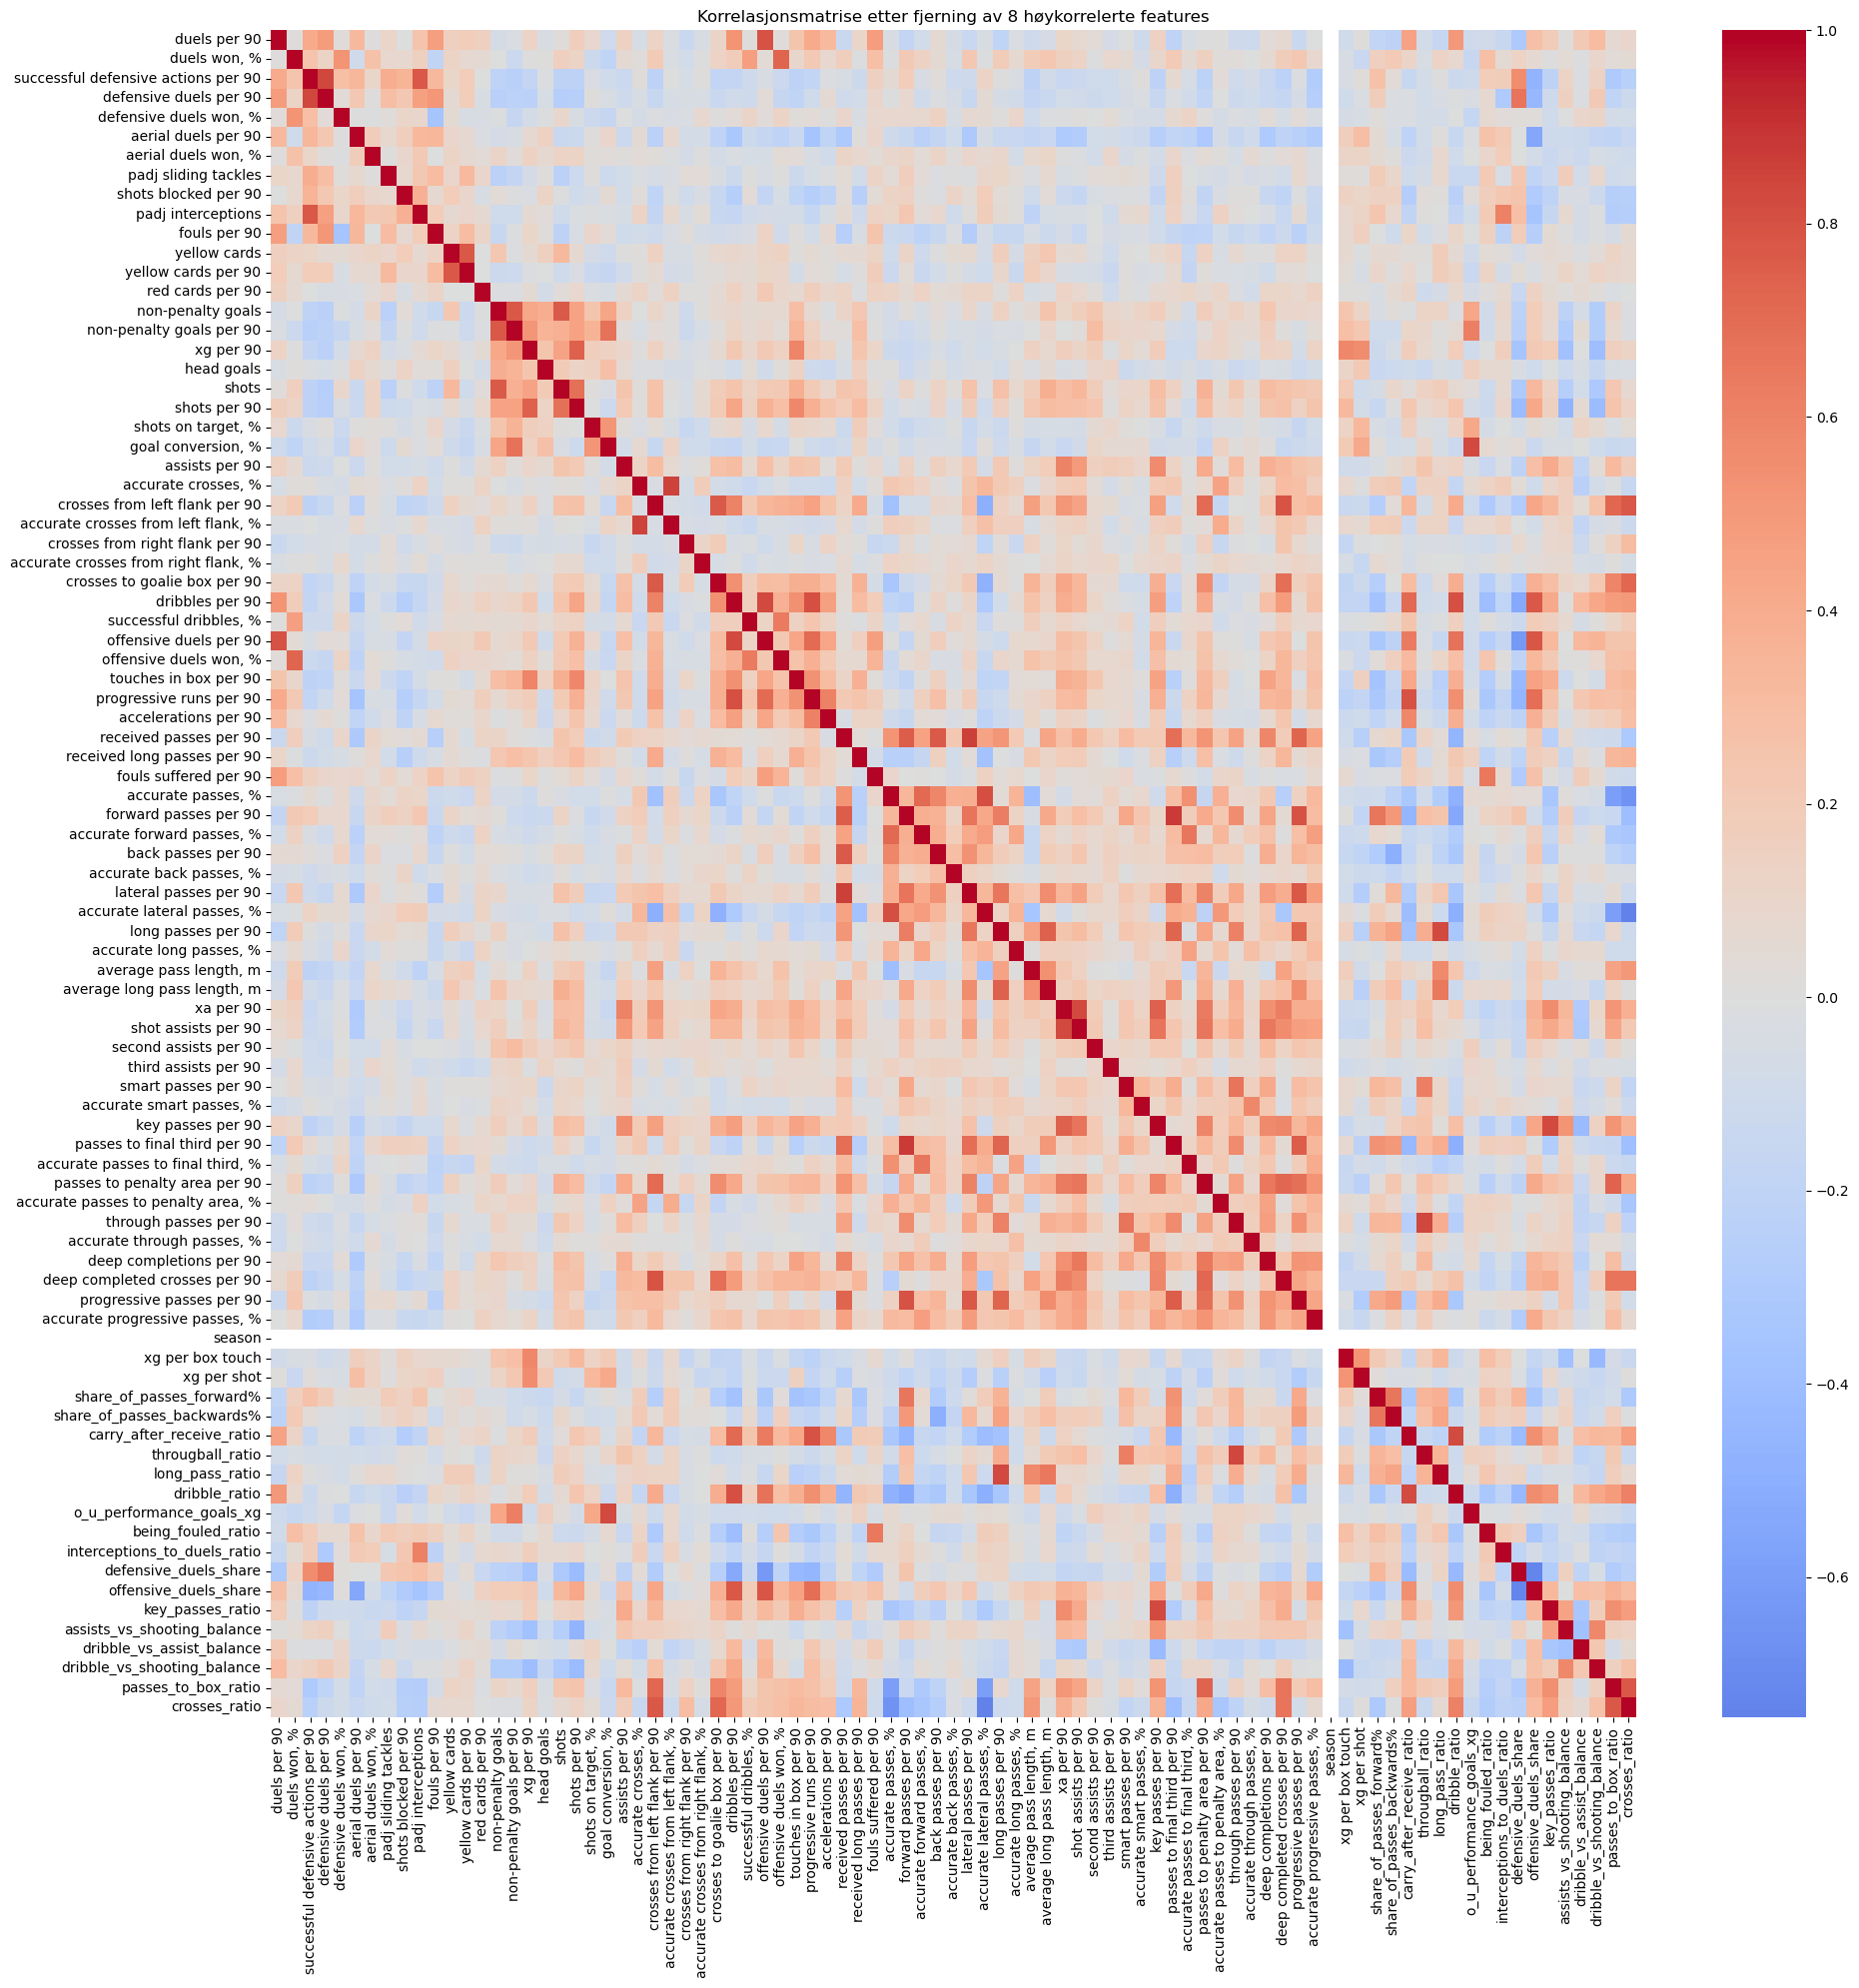

Maksimal korrelasjon i det nye settet: 0.871

=== FINAL DATAFRAME ===
Total antall kolonner i final df: 104
Antall ekskluderte kolonner: 17
Antall metrics kolonner: 87


In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1️⃣ Definer kolonner som skal ekskluderes fra korrelasjonstest ---
excluded_columns = [
    'player', 'squad', 'club today', 'season', 'league', 'position', 
    'age', 'market value', 'contract months left', 'matches played', 'minutes played', 
    'birth country', 'passport country', 'foot', 'height', 'weight', 'on loan',
]

# --- 2️⃣ Velg alle kolonner du vil analysere ---
metrics = ['duels per 90', 'duels won, %','successful defensive actions per 90', 'defensive duels per 90', 'defensive duels won, %', 'aerial duels per 90', 'aerial duels won, %', 'sliding tackles per 90', 'padj sliding tackles', 'shots blocked per 90', 'interceptions per 90', 'padj interceptions', 'fouls per 90', 'yellow cards', 'yellow cards per 90', 'red cards', 'red cards per 90', 'successful attacking actions per 90', 'goals per 90', 'non-penalty goals', 'non-penalty goals per 90', 'xg per 90', 'head goals', 'head goals per 90', 'shots', 'shots per 90', 'shots on target, %', 'goal conversion, %', 'assists per 90', 'crosses per 90', 'accurate crosses, %', 'crosses from left flank per 90', 'accurate crosses from left flank, %', 'crosses from right flank per 90', 'accurate crosses from right flank, %', 'crosses to goalie box per 90', 'dribbles per 90', 'successful dribbles, %', 'offensive duels per 90', 'offensive duels won, %', 'touches in box per 90', 'progressive runs per 90', 'accelerations per 90', 'received passes per 90', 'received long passes per 90', 'fouls suffered per 90', 'passes per 90', 'accurate passes, %', 'forward passes per 90', 'accurate forward passes, %', 'back passes per 90', 'accurate back passes, %', 'lateral passes per 90', 'accurate lateral passes, %', 'long passes per 90', 'accurate long passes, %', 'average pass length, m', 'average long pass length, m', 'xa per 90', 'shot assists per 90', 'second assists per 90', 'third assists per 90', 'smart passes per 90', 'accurate smart passes, %', 'key passes per 90', 'passes to final third per 90', 'accurate passes to final third, %', 'passes to penalty area per 90', 'accurate passes to penalty area, %', 'through passes per 90', 'accurate through passes, %', 'deep completions per 90', 'deep completed crosses per 90', 'progressive passes per 90', 'accurate progressive passes, %', 'season', 'xg per box touch', 'xg per shot', 'share_of_passes_forward%', 'share_of_passes_backwards%', 'carry_after_receive_ratio', 'througball_ratio', 'long_pass_ratio', 'dribble_ratio', 'o_u_performance_goals_xg', 'being_fouled_ratio',  'interceptions_to_duels_ratio', 'defensive_duels_share', 'offensive_duels_share', 'key_passes_ratio', 'assists_vs_shooting_balance', 'dribble_vs_assist_balance', 'dribble_vs_shooting_balance','passes_to_box_ratio', 'crosses_ratio']
# --- 3️⃣ Opprett df og lagre ekskluderte kolonner ---
df = df.copy()

# Lagre de ekskluderte kolonnene separat
excluded_data = df[excluded_columns].copy()

# --- 4️⃣ Beregn korrelasjonsmatrise (kun på metrics) ---
corr = df[metrics].corr(method='pearson')

# --- 5️⃣ Identifiser og fjern høykorrelerte features ---
protected_metrics = ['dribbles per 90']
high_correlation_threshold = 0.9

# Finn alle par med korrelasjon > 0.9
high_corr_pairs = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > high_correlation_threshold:
            high_corr_pairs.append({
                'metric1': corr.columns[i],
                'metric2': corr.columns[j], 
                'correlation': corr.iloc[i, j]
            })

# Sorter etter korrelasjonsstyrke
high_corr_pairs = sorted(high_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True)

# Identifiser hvilke metrics som skal fjernes
metrics_to_remove = set()

print("=== HØYKORRELERTE FEATURES ( > 0.9) ===")
for pair in high_corr_pairs:
    metric1, metric2, correlation = pair['metric1'], pair['metric2'], pair['correlation']
    
    # Sjekk om noen av metricsene er beskyttet
    protected_in_pair = [m for m in [metric1, metric2] if m in protected_metrics]
    
    if protected_in_pair:
        # Beskyttet metric funnet - fjern den andre
        metric_to_remove = metric2 if metric1 in protected_metrics else metric1
        if metric_to_remove not in metrics_to_remove:
            metrics_to_remove.add(metric_to_remove)
            print(f"Korrelasjon: {correlation:.3f}")
            print(f"  - Beskyttet: {protected_in_pair[0]}")
            print(f"  → Fjernes: {metric_to_remove}\n")
    else:
        # Ingen beskyttet metrics - fjern den som har høyest gjennomsnittlig korrelasjon
        avg_corr1 = abs(corr[metric1]).mean()
        avg_corr2 = abs(corr[metric2]).mean()
        
        metric_to_remove = metric1 if avg_corr1 > avg_corr2 else metric2
        
        if metric_to_remove not in metrics_to_remove:
            metrics_to_remove.add(metric_to_remove)
            print(f"Korrelasjon: {correlation:.3f}")
            print(f"  - {metric1} (gj.snitt korr: {avg_corr1:.3f})")
            print(f"  - {metric2} (gj.snitt korr: {avg_corr2:.3f})")
            print(f"  → Fjernes: {metric_to_remove}\n")

# --- 6️⃣ Oppdater metrics-listen ---
filtered_metrics = [m for m in metrics if m not in metrics_to_remove]

print(f"\n=== RESULTAT ===")
print(f"Opprinnelig antall metrics: {len(metrics)}")
print(f"Fjernet {len(metrics_to_remove)} metrics: {list(metrics_to_remove)}")
print(f"Gjenstående antall metrics: {len(filtered_metrics)}")

# --- 7️⃣ Vis korrelasjonsmatrise for de gjenstående metricsene ---
plt.figure(figsize=(20, 20))
sns.heatmap(df[filtered_metrics].corr(), cmap='coolwarm', center=0, annot=False, fmt=".2f")
plt.title(f'Korrelasjonsmatrise etter fjerning av {len(metrics_to_remove)} høykorrelerte features')
plt.tight_layout()
plt.show()

# --- 8️⃣ Sjekk maks korrelasjon i det nye settet ---
if len(filtered_metrics) > 0:
    max_corr_after = df[filtered_metrics].corr().abs()
    np.fill_diagonal(max_corr_after.values, 0)  # Sett diagonal til 0 for å ignorere selve korrelasjon
    max_remaining_corr = max_corr_after.max().max()
    print(f"Maksimal korrelasjon i det nye settet: {max_remaining_corr:.3f}")

# --- 9️⃣ Kombiner filtrerte metrics med ekskluderte kolonner ---
# Behold kun de filtrerte metrics + de ekskluderte kolonnene
final_columns = excluded_columns + filtered_metrics
df = df[final_columns]

print(f"\n=== FINAL DATAFRAME ===")
print(f"Total antall kolonner i final df: {len(df.columns)}")
print(f"Antall ekskluderte kolonner: {len(excluded_columns)}")
print(f"Antall metrics kolonner: {len(filtered_metrics)}")

In [29]:
filtered_metrics

['duels per 90',
 'duels won, %',
 'successful defensive actions per 90',
 'defensive duels per 90',
 'defensive duels won, %',
 'aerial duels per 90',
 'aerial duels won, %',
 'padj sliding tackles',
 'shots blocked per 90',
 'padj interceptions',
 'fouls per 90',
 'yellow cards',
 'yellow cards per 90',
 'red cards per 90',
 'non-penalty goals',
 'non-penalty goals per 90',
 'xg per 90',
 'head goals',
 'shots',
 'shots per 90',
 'shots on target, %',
 'goal conversion, %',
 'assists per 90',
 'accurate crosses, %',
 'crosses from left flank per 90',
 'accurate crosses from left flank, %',
 'crosses from right flank per 90',
 'accurate crosses from right flank, %',
 'crosses to goalie box per 90',
 'dribbles per 90',
 'successful dribbles, %',
 'offensive duels per 90',
 'offensive duels won, %',
 'touches in box per 90',
 'progressive runs per 90',
 'accelerations per 90',
 'received passes per 90',
 'received long passes per 90',
 'fouls suffered per 90',
 'accurate passes, %',
 'f

In [31]:
metrics_to_remove

{'crosses per 90',
 'goals per 90',
 'head goals per 90',
 'interceptions per 90',
 'passes per 90',
 'red cards',
 'sliding tackles per 90',
 'successful attacking actions per 90'}

In [33]:
col_list =df.columns.to_list()
print(col_list) #print the columns 

['player', 'squad', 'club today', 'season', 'league', 'position', 'age', 'market value', 'contract months left', 'matches played', 'minutes played', 'birth country', 'passport country', 'foot', 'height', 'weight', 'on loan', 'duels per 90', 'duels won, %', 'successful defensive actions per 90', 'defensive duels per 90', 'defensive duels won, %', 'aerial duels per 90', 'aerial duels won, %', 'padj sliding tackles', 'shots blocked per 90', 'padj interceptions', 'fouls per 90', 'yellow cards', 'yellow cards per 90', 'red cards per 90', 'non-penalty goals', 'non-penalty goals per 90', 'xg per 90', 'head goals', 'shots', 'shots per 90', 'shots on target, %', 'goal conversion, %', 'assists per 90', 'accurate crosses, %', 'crosses from left flank per 90', 'accurate crosses from left flank, %', 'crosses from right flank per 90', 'accurate crosses from right flank, %', 'crosses to goalie box per 90', 'dribbles per 90', 'successful dribbles, %', 'offensive duels per 90', 'offensive duels won, %'

In [36]:
len(df)

248

In [38]:
df[df['squad']=='Viking']

,player,squad,club today,season,league,position,age,market value,contract months left,matches played,minutes played,birth country,passport country,foot,height,weight,on loan,duels per 90,"duels won, %",successful defensive actions per 90,defensive duels per 90,"defensive duels won, %",aerial duels per 90,"aerial duels won, %",padj sliding tackles,shots blocked per 90,padj interceptions,fouls per 90,yellow cards,yellow cards per 90,red cards per 90,non-penalty goals,non-penalty goals per 90,xg per 90,head goals,shots,shots per 90,"shots on target, %","goal conversion, %",assists per 90,"accurate crosses, %",crosses from left flank per 90,"accurate crosses from left flank, %",crosses from right flank per 90,"accurate crosses from right flank, %",crosses to goalie box per 90,dribbles per 90,"successful dribbles, %",offensive duels per 90,"offensive duels won, %",touches in box per 90,progressive runs per 90,accelerations per 90,received passes per 90,received long passes per 90,fouls suffered per 90,"accurate passes, %",forward passes per 90,"accurate forward passes, %",back passes per 90,"accurate back passes, %",lateral passes per 90,"accurate lateral passes, %",long passes per 90,"accurate long passes, %","average pass length, m","average long pass length, m",xa per 90,shot assists per 90,second assists per 90,third assists per 90,smart passes per 90,"accurate smart passes, %",key passes per 90,passes to final third per 90,"accurate passes to final third, %",passes to penalty area per 90,"accurate passes to penalty area, %",through passes per 90,"accurate through passes, %",deep completions per 90,deep completed crosses per 90,progressive passes per 90,"accurate progressive passes, %",season,xg per box touch,xg per shot,share_of_passes_forward%,share_of_passes_backwards%,carry_after_receive_ratio,througball_ratio,long_pass_ratio,dribble_ratio,o_u_performance_goals_xg,being_fouled_ratio,interceptions_to_duels_ratio,defensive_duels_share,offensive_duels_share,key_passes_ratio,assists_vs_shooting_balance,dribble_vs_assist_balance,dribble_vs_shooting_balance,passes_to_box_ratio
1905,E. Austbø,Viking,Viking,None,Norway Eliteserien,"LW, LWF",20,0,24,26,1853,Norway,Norway,right,172,64,no,18.21,50.4,3.59,3.45,61.97,0.78,37.5,0.53,0.05,1.45,0.44,2,0.1,0.0,5,0.24,0.2,1,49,2.38,38.78,10.204,0.24,40.23,3.3,41.18,0.83,35.29,1.17,8.5,57.71,12.39,50.98,4.81,4.27,0.44,25.6,2.09,1.02,80.49,6.36,73.28,8.79,95.03,13.07,80.67,1.51,74.19,18.33,31.51,0.2,1.46,0.05,0.05,0.29,50.0,0.83,2.53,71.15,3.98,58.54,0.44,44.44,1.85,1.6,4.81,86.87,None,0.04,0.08,0.18,-0.25,0.17,0.01,0.04,0.33,1.2,0.08,0.31,0.19,0.68,0.02,0.35,10.24,3.57,0.11


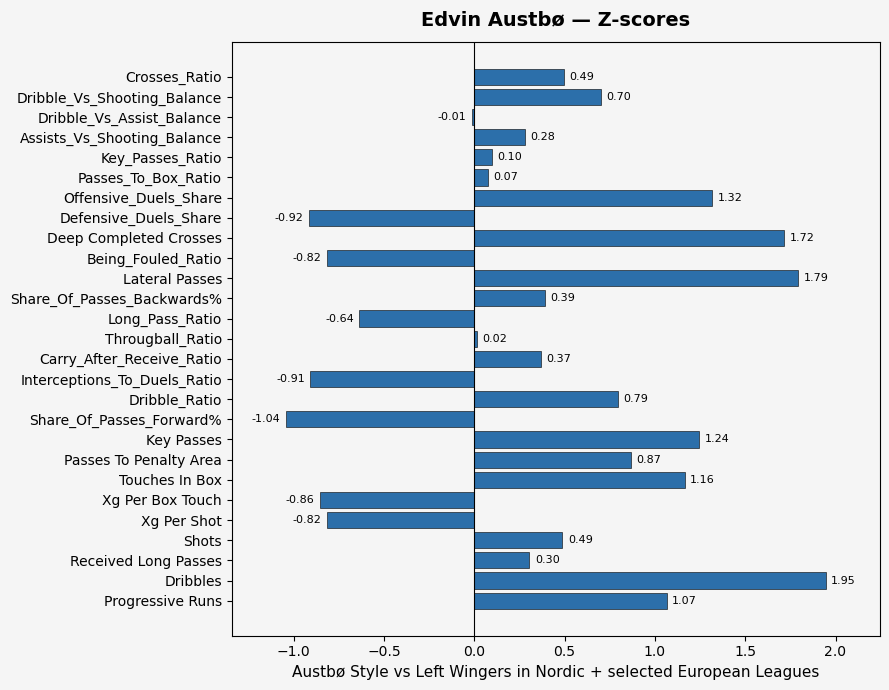

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) features du vil se på
features = [
    'progressive runs per 90',
    'dribbles per 90',
    'received long passes per 90',
    'shots per 90',
    'xg per shot',
    'xg per box touch',
    'touches in box per 90',
    'passes to penalty area per 90',
    'key passes per 90',
    'share_of_passes_forward%',
    'dribble_ratio',
    'interceptions_to_duels_ratio',
    'carry_after_receive_ratio',
    'througball_ratio',
    'long_pass_ratio',
    'share_of_passes_backwards%',
    'lateral passes per 90',
     'being_fouled_ratio',
    'deep completed crosses per 90',
     'defensive_duels_share',
     'offensive_duels_share',
     'passes_to_box_ratio',
     'key_passes_ratio',
     'assists_vs_shooting_balance',
     'dribble_vs_assist_balance',
     'dribble_vs_shooting_balance',
    'crosses_ratio',
]


# 2) Opprett kopi for z-score beregninger
z_style_df = df.copy()

# z-score per kolonne på z_style_df
for col in features:
    col_mean = z_style_df[col].mean()
    col_std = z_style_df[col].std()
    if col_std == 0 or np.isnan(col_std):
        z_style_df[col + '_z'] = 0
    else:
        z_style_df[col + '_z'] = (z_style_df[col] - col_mean) / col_std

# 3) hent Lamine Yamal fra z_style_df
target_row = z_style_df[z_style_df['player'] == 'E. Austbø']
if target_row.empty:
    raise ValueError("Fant ikke target player i filtered_df")

target_z = [target_row[f + '_z'].iloc[0] for f in features]
labels = [f.replace(' per 90', '').title() for f in features]

# 4) plot
fig, ax = plt.subplots(figsize=(9, 7))

# bakgrunn
fig.patch.set_facecolor('whitesmoke')
ax.set_facecolor('whitesmoke')

bars = ax.barh(
    range(len(features)),
    target_z,
    color='#2c6faa',    # litt dypere blå
    edgecolor='black',
    linewidth=0.4
)

# akse og tittel
ax.set_yticks(range(len(features)))
ax.set_yticklabels(labels, fontsize=10)
ax.set_xlabel('Austbø Style vs Left Wingers in Nordic + selected European Leagues', fontsize=11)
ax.set_title('Edvin Austbø — Z-scores', fontsize=14, weight='bold', pad=12)

# vertikal nullinje
ax.axvline(0, color='black', linewidth=0.8)

# legg på tall på stengene
for i, v in enumerate(target_z):
    ax.text(
        v + (0.03 if v >= 0 else -0.03),
        i,
        f"{v:.2f}",
        va='center',
        ha='left' if v >= 0 else 'right',
        fontsize=8,
        color='black'
    )

# litt margin på x
xmin = min(target_z) - 0.3
xmax = max(target_z) + 0.3
ax.set_xlim(xmin, xmax)

plt.tight_layout()

# 5) lagre
out_path = VIZ_DIR / "z_scores.jpg"
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()

In [37]:
col_list =df.columns.to_list()
print(col_list) #print the columns 

['player', 'squad', 'club today', 'season', 'league', 'position', 'age', 'market value', 'contract months left', 'matches played', 'minutes played', 'birth country', 'passport country', 'foot', 'height', 'weight', 'on loan', 'duels per 90', 'duels won, %', 'successful defensive actions per 90', 'defensive duels per 90', 'defensive duels won, %', 'aerial duels per 90', 'aerial duels won, %', 'padj sliding tackles', 'shots blocked per 90', 'padj interceptions', 'fouls per 90', 'yellow cards', 'yellow cards per 90', 'red cards per 90', 'non-penalty goals', 'non-penalty goals per 90', 'xg per 90', 'head goals', 'shots', 'shots per 90', 'shots on target, %', 'goal conversion, %', 'assists per 90', 'accurate crosses, %', 'crosses from left flank per 90', 'accurate crosses from left flank, %', 'crosses from right flank per 90', 'accurate crosses from right flank, %', 'crosses to goalie box per 90', 'dribbles per 90', 'successful dribbles, %', 'offensive duels per 90', 'offensive duels won, %'

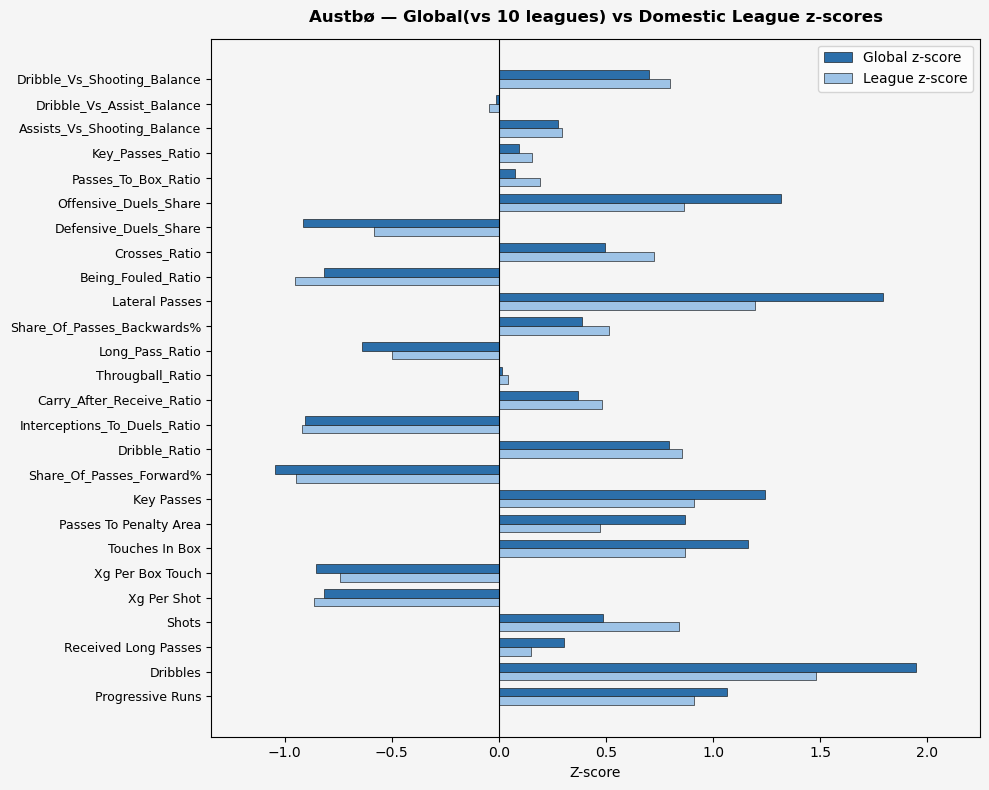

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0) utgangspunkt – behold originalen urørt
base_df = df  # original
z_df = df.copy()  # jobbkopi hvor vi legger z-kolonner

# 1) features du vil se på
features = [
    'progressive runs per 90',
    'dribbles per 90',
    'received long passes per 90',
    'shots per 90',
    'xg per shot',
    'xg per box touch',
    'touches in box per 90',
    'passes to penalty area per 90',
    'key passes per 90',
    'share_of_passes_forward%',
    'dribble_ratio',
    'interceptions_to_duels_ratio',
    'carry_after_receive_ratio',
    'througball_ratio',
    'long_pass_ratio',
    'share_of_passes_backwards%',
    'lateral passes per 90',
     'being_fouled_ratio',
     'crosses_ratio',
     'defensive_duels_share',
     'offensive_duels_share',
     'passes_to_box_ratio',
     'key_passes_ratio',
     'assists_vs_shooting_balance',
     'dribble_vs_assist_balance',
     'dribble_vs_shooting_balance',
]

# 2) GLOBAL z-score på kopien
for col in features:
    col_mean = z_df[col].mean()
    col_std = z_df[col].std()
    if col_std == 0 or np.isnan(col_std):
        z_df[col + '_z_global'] = 0
    else:
        z_df[col + '_z_global'] = (z_df[col] - col_mean) / col_std

# 3) LOKAL (liga-basert) z-score på kopien
def z_in_group(s: pd.Series) -> pd.Series:
    std = s.std()
    if std == 0 or np.isnan(std):
        return pd.Series(0.0, index=s.index)
    return (s - s.mean()) / std

for col in features:
    z_df[col + '_z_league'] = (
        z_df.groupby('league')[col]
            .transform(z_in_group)
    )

# 4) hent Ausbø fra kopien
target_row = z_df[z_df['player'] == 'E. Austbø']
if target_row.empty:
    raise ValueError("Fant ikke Ausbø i filtered_df")

# 5) lag lister til plotting
target_z_global = [target_row[f + '_z_global'].iloc[0] for f in features]
target_z_league = [target_row[f + '_z_league'].iloc[0] for f in features]
labels = [f.replace(' per 90', '').title() for f in features]

# 6) plot – to serier ved siden av hverandre
fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor('whitesmoke')
ax.set_facecolor('whitesmoke')

y_pos = np.arange(len(features))
height = 0.35

ax.barh(y_pos + height/2, target_z_global, height,
        label='Global z-score', color='#2c6faa', edgecolor='black', linewidth=0.4)
ax.barh(y_pos - height/2, target_z_league, height,
        label='League z-score', color='#9ec3e6', edgecolor='black', linewidth=0.4)

ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=9)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Z-score')
ax.set_title('Austbø — Global(vs 10 leagues) vs Domestic League z-scores', fontsize=12, weight='bold', pad=12)
ax.legend(loc='upper right')

xmin = min(min(target_z_global), min(target_z_league)) - 0.3
xmax = max(max(target_z_global), max(target_z_league)) + 0.3
ax.set_xlim(xmin, xmax)

plt.tight_layout()
out_path = VIZ_DIR / "z_scores_vs_global.jpg"
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [41]:
len(df)

248

In [43]:
len(df.squad.unique())

173

In [45]:
col_list =df.columns.to_list()
print(col_list) #print the columns 

['player', 'squad', 'club today', 'season', 'league', 'position', 'age', 'market value', 'contract months left', 'matches played', 'minutes played', 'birth country', 'passport country', 'foot', 'height', 'weight', 'on loan', 'duels per 90', 'duels won, %', 'successful defensive actions per 90', 'defensive duels per 90', 'defensive duels won, %', 'aerial duels per 90', 'aerial duels won, %', 'padj sliding tackles', 'shots blocked per 90', 'padj interceptions', 'fouls per 90', 'yellow cards', 'yellow cards per 90', 'red cards per 90', 'non-penalty goals', 'non-penalty goals per 90', 'xg per 90', 'head goals', 'shots', 'shots per 90', 'shots on target, %', 'goal conversion, %', 'assists per 90', 'accurate crosses, %', 'crosses from left flank per 90', 'accurate crosses from left flank, %', 'crosses from right flank per 90', 'accurate crosses from right flank, %', 'crosses to goalie box per 90', 'dribbles per 90', 'successful dribbles, %', 'offensive duels per 90', 'offensive duels won, %'

In [47]:
df.head()

,player,squad,club today,season,league,position,age,market value,contract months left,matches played,minutes played,birth country,passport country,foot,height,weight,on loan,duels per 90,"duels won, %",successful defensive actions per 90,defensive duels per 90,"defensive duels won, %",aerial duels per 90,"aerial duels won, %",padj sliding tackles,shots blocked per 90,padj interceptions,fouls per 90,yellow cards,yellow cards per 90,red cards per 90,non-penalty goals,non-penalty goals per 90,xg per 90,head goals,shots,shots per 90,"shots on target, %","goal conversion, %",assists per 90,"accurate crosses, %",crosses from left flank per 90,"accurate crosses from left flank, %",crosses from right flank per 90,"accurate crosses from right flank, %",crosses to goalie box per 90,dribbles per 90,"successful dribbles, %",offensive duels per 90,"offensive duels won, %",touches in box per 90,progressive runs per 90,accelerations per 90,received passes per 90,received long passes per 90,fouls suffered per 90,"accurate passes, %",forward passes per 90,"accurate forward passes, %",back passes per 90,"accurate back passes, %",lateral passes per 90,"accurate lateral passes, %",long passes per 90,"accurate long passes, %","average pass length, m","average long pass length, m",xa per 90,shot assists per 90,second assists per 90,third assists per 90,smart passes per 90,"accurate smart passes, %",key passes per 90,passes to final third per 90,"accurate passes to final third, %",passes to penalty area per 90,"accurate passes to penalty area, %",through passes per 90,"accurate through passes, %",deep completions per 90,deep completed crosses per 90,progressive passes per 90,"accurate progressive passes, %",season,xg per box touch,xg per shot,share_of_passes_forward%,share_of_passes_backwards%,carry_after_receive_ratio,througball_ratio,long_pass_ratio,dribble_ratio,o_u_performance_goals_xg,being_fouled_ratio,interceptions_to_duels_ratio,defensive_duels_share,offensive_duels_share,key_passes_ratio,assists_vs_shooting_balance,dribble_vs_assist_balance,dribble_vs_shooting_balance,passes_to_box_ratio,crosses_ratio
36,A. Smed,Hvidovre,Hvidovre,None,Denmark 1. div,"LWF, CF, LCMF",28,300000,0,18,1554,Denmark,Denmark,right,182,73,no,11.64,47.26,6.25,3.82,68.18,2.37,21.95,1.05,0.12,3.09,0.81,2,0.12,0.00,2,0.12,0.12,0,33,1.91,21.21,6.061,0.23,26.79,1.39,29.17,1.85,25.00,0.64,1.04,55.56,3.36,46.55,3.01,1.16,0.12,22.30,2.32,0.81,72.81,7.82,64.44,6.66,92.17,9.73,67.26,2.49,37.21,18.28,37.33,0.12,0.87,0.12,0.00,0.12,50.00,0.41,3.07,60.38,3.24,53.57,0.17,66.67,1.33,0.81,4.81,67.47,None,0.04,0.06,0.26,-0.22,0.05,0.01,0.08,0.05,1.00,0.24,0.71,0.33,0.29,0.01,0.21,2.54,0.54,0.11,0.11
41,C. Tue Jensen,HB Køge,HB Køge,None,Denmark 1. div,"LWF, LW, LCMF",25,150000,0,18,1521,Denmark,Denmark,right,0,0,no,12.49,41.23,4.79,4.08,52.17,2.25,26.32,0.13,0.30,2.83,0.83,0,0.00,0.00,4,0.24,0.24,0,38,2.25,36.84,13.158,0.00,56.25,0.59,50.00,0.36,66.67,0.12,1.07,50.00,4.62,32.05,1.66,0.83,0.12,15.09,1.01,1.30,76.41,6.86,63.79,4.20,92.96,6.51,80.91,1.01,64.71,16.00,21.60,0.05,0.36,0.00,0.12,0.18,66.67,0.06,2.60,68.18,2.07,71.43,0.12,50.00,0.83,0.53,3.85,53.85,None,0.14,0.11,0.31,-0.19,0.06,0.01,0.05,0.07,1.25,0.28,0.62,0.33,0.37,0.00,0.03,17.83,0.48,0.09,0.04
59,J. Wielzen,Middelfart,Middelfart,None,Denmark 1. div,"LW, RW, CF",23,0,18,18,1376,Netherlands,Netherlands,right,0,0,no,17.40,35.34,4.64,3.99,60.66,2.22,14.71,0.00,0.26,2.49,0.59,3,0.20,0.00,4,0.26,0.26,0,36,2.35,41.67,11.111,0.07,35.14,1.11,47.06,1.31,25.00,0.39,3.47,56.60,9.48,32.41,2.49,2.94,0.59,20.41,1.70,0.72,75.00,5.63,58.14,8.57,93.13,7.13,68.81,1.24,31.58,18.70,24.43,0.07,0.65,0.07,0.00,0.13,50.00,0.33,2.03,45.16,2.75,38.10,0.13,50.00,0.46,0.92,3.27,54.00,None,0.10,0.11,0.22,-0.33,0.14,0.01,0.05,0.17,1.00,0.08,0.56,0.23,0.54,0.01,0.14,10.52,1.48,0.11,0.09
67,L. Sandgrav,Lyngby,Lyngby,None,Denmark 1. div,"LW, LCMF, RCMF",21,100000,30,15,1237,Denmark,Denmark,right,184,76,no,17.24,47.26,6.77,4.44,63.93,2.04,50.00,0.27,0.22

In [49]:
# viser både kolonnenavn og datatype
for col, dtype in df.dtypes.items():
    print(f"{col}: {dtype}")

player: object
squad: object
club today: object
season: object
league: object
position: object
age: int32
market value: int64
contract months left: int64
matches played: int64
minutes played: int64
birth country: object
passport country: object
foot: object
height: int64
weight: int64
on loan: object
duels per 90: float64
duels won, %: float64
successful defensive actions per 90: float64
defensive duels per 90: float64
defensive duels won, %: float64
aerial duels per 90: float64
aerial duels won, %: float64
padj sliding tackles: float64
shots blocked per 90: float64
padj interceptions: float64
fouls per 90: float64
yellow cards: int64
yellow cards per 90: float64
red cards per 90: float64
non-penalty goals: int64
non-penalty goals per 90: float64
xg per 90: float64
head goals: int64
shots: int64
shots per 90: float64
shots on target, %: float64
goal conversion, %: float64
assists per 90: float64
accurate crosses, %: float64
crosses from left flank per 90: float64
accurate crosses from 

In [51]:
df.describe

<bound method NDFrame.describe of                player          squad     club today season          league  \
36            A. Smed       Hvidovre       Hvidovre   None  Denmark 1. div   
41      C. Tue Jensen        HB Køge        HB Køge   None  Denmark 1. div   
59         J. Wielzen     Middelfart     Middelfart   None  Denmark 1. div   
67        L. Sandgrav         Lyngby         Lyngby   None  Denmark 1. div   
71       V. Rasmussen          Hobro          Hobro   None  Denmark 1. div   
...               ...            ...            ...    ...             ...   
5645        A. Hbouch         Annecy         Annecy   None         Ligue 2   
5652  Z. Davitashvili  Saint-Étienne  Saint-Étienne   None         Ligue 2   
5660    A. El Farissi       Boulogne       Boulogne   None         Ligue 2   
5680           G. Ott       Guingamp       Guingamp   None         Ligue 2   
5713      K. Nakamura          Reims          Reims   None         Ligue 2   

            position  age  ma

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 248 entries, 36 to 5713
Columns: 104 entries, player to crosses_ratio
dtypes: float64(82), int32(1), int64(10), object(11)
memory usage: 202.5+ KB


In [67]:
col_list =df.columns.to_list()
print(col_list) #print the columns 

['player', 'squad', 'club today', 'season', 'league', 'position', 'age', 'market value', 'contract months left', 'matches played', 'minutes played', 'birth country', 'passport country', 'foot', 'height', 'weight', 'on loan', 'duels per 90', 'duels won, %', 'successful defensive actions per 90', 'defensive duels per 90', 'defensive duels won, %', 'aerial duels per 90', 'aerial duels won, %', 'padj sliding tackles', 'shots blocked per 90', 'padj interceptions', 'fouls per 90', 'yellow cards', 'yellow cards per 90', 'red cards per 90', 'non-penalty goals', 'non-penalty goals per 90', 'xg per 90', 'head goals', 'shots', 'shots per 90', 'shots on target, %', 'goal conversion, %', 'assists per 90', 'accurate crosses, %', 'crosses from left flank per 90', 'accurate crosses from left flank, %', 'crosses from right flank per 90', 'accurate crosses from right flank, %', 'crosses to goalie box per 90', 'dribbles per 90', 'successful dribbles, %', 'offensive duels per 90', 'offensive duels won, %'

In [71]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


class StyleSimilarityModel:
    def __init__(
        self,
        df: pd.DataFrame,
        target_player: str,
        style_weights: dict | None = None,
        exclude_columns: list | None = None,
    ):
        """
        df: dataframe med alle spillerne
        target_player: navnet på spilleren du vil måle likhet mot
        style_weights: vektene på hovedattributtene
        exclude_columns: kolonner som ikke skal normaliseres
        """
        self.original_df = df  # lagre original
        self.df = df.copy()    # vi jobber på kopi

        self.target_player = target_player

        # default-vekter
        self.style_weights = style_weights or {
            "carry_att": 0.20,
            "dribble_att": 0.25,
            "ball_involvement_att": 0.10,
            "finding_chances_att": 0.10,
            "assisting_chances_att": 0.20,
            "defensive_att": 0.05,
            "passing_style_att": 0.10,
        }

        # kolonner vi ikke vil røre når vi normaliserer
        self.exclude_columns = exclude_columns or [
            "player",
            "squad",
            "club today",
            "season",
            "league",
            "main position",
            "position",
            "age",
            "market value",
            "contract months left",
            "matches played",
            "minutes played",
            "birth country",
            "passport country",
            "foot",
            "height",
            "weight",
            "on loan",
            "position_group",
        ]

        # style-kolonner vi lager i build_style_attributes
        self.style_cols = [
            "carry_att",
            "dribble_att",
            "ball_involvement_att",
            "finding_chances_att",
            "assisting_chances_att",
            "defensive_att",
            "passing_style_att",
        ]

    # ---------- hjelpesaker ----------
    @staticmethod
    def _normalize_series(s: pd.Series) -> pd.Series:
        smin = s.min()
        smax = s.max()
        if pd.isna(smin) or pd.isna(smax) or smax == smin:
            return pd.Series(0.0, index=s.index)
        return (s - smin) / (smax - smin)

    # ---------- pipeline-steg ----------
    def normalize_numeric(self):
        """Normaliser alle numeriske kolonner (0–1) bortsett fra de vi ekskluderer."""
        cols_to_norm = [
            c
            for c in self.df.columns
            if c not in self.exclude_columns
            and self.df[c].dtype in ("int64", "float64")
            and not c.endswith("_att")  # ikke normaliser style-kolonner vi lager senere
        ]

        for col in cols_to_norm:
            # flytt opp hvis negative
            if self.df[col].min() < 0:
                self.df[col] = self.df[col] + abs(self.df[col].min())
            self.df[col] = self._normalize_series(self.df[col])

    def build_style_attributes(self):
        """
        Lager de 7 hoved-attributtene dine, tilpasset faktiske kolonnenavn i df.
        Forutsetter at normalize_numeric() er kjørt først.
        """
        d = self.df  # kort navn

        # disse kolonnene må finnes
        required = [
            "progressive runs per 90",
            "carry_after_receive_ratio",
            "dribbles per 90",
            "dribble_ratio",
            'received passes per 90',
            "shots per 90",
            "touches in box per 90",
            "xg per shot",
            "passes to penalty area per 90",
            "througball_ratio",
            "key passes per 90",
            "defensive duels per 90",
            "padj interceptions",     
            "share_of_passes_forward%",
            "share_of_passes_backwards%",
            "lateral passes per 90",
            "long_pass_ratio",
            "offensive_duels_share",
            "defensive_duels_share",
            "key_passes_ratio",
            'interceptions_to_duels_ratio',
            'crosses_ratio',
        ]
        missing = [c for c in required if c not in d.columns]
        if missing:
            raise KeyError(f"Mangler kolonner i df: {missing}")

        # carry / progressive aksjoner
        d["carry_att"] = (
            d["progressive runs per 90"] * 0.7
            + d["carry_after_receive_ratio"] * 0.3
        )

        # dribleprofil – NB: ingen komma på slutten!
        d["dribble_att"] = (
            d["dribbles per 90"] * 0.7
            + d["dribble_ratio"] * 0.3
        )

        # involvering: involvert i oppspill + dueller
        d["ball_involvement_att"] = (
            d["received passes per 90"] * 0.5
            + d["offensive_duels_share"] * 0.25
            + d["defensive_duels_share"] * 0.25
        )

        # egen avslutning / trussel
        d["finding_chances_att"] = (
            d["shots per 90"] * 0.4
            + d["touches in box per 90"] * 0.3
            + d["xg per shot"] * 0.3
        )

        # sjanseskapende spill – bruker volum + stil
        d["assisting_chances_att"] = (
            d["passes_to_box_ratio"] * 0.25
            + d["througball_ratio"] * 0.25
            + d["key_passes_ratio"] * 0.25
            + d["crosses_ratio"] * 0.25
        )

        # defensiv involvering
        d["defensive_att"] = (
            d["defensive duels per 90"] * 0.4
            + d["padj interceptions"] * 0.3
            + d["interceptions_to_duels_ratio"] * 0.3
        )

        # pasningsstil / retning
        d["passing_style_att"] = (
            d["share_of_passes_forward%"] * 0.25
            + d["share_of_passes_backwards%"] * 0.25
            + d["lateral passes per 90"] * 0.25
            + d["long_pass_ratio"] * 0.25
        )

        # normaliser style-kolonnene til [0,1]
        for col in self.style_cols:
            d[col] = self._normalize_series(d[col])

        d[self.style_cols] = d[self.style_cols].fillna(0.0)

    def compute_cosine_similarity(self):
        """Regner ut cosine similarity mot target for alle spillere."""
        d = self.df
        # vekt alle style-kolonner
        X_style_weighted = d[self.style_cols].mul(self.style_weights, axis=1).values

        target_row = d[d["player"] == self.target_player]
        if target_row.empty:
            raise ValueError(f"Fant ikke spilleren {self.target_player} i datasettet.")
        target_vec = target_row[self.style_cols].mul(self.style_weights, axis=1).values

        sims = cosine_similarity(target_vec, X_style_weighted)[0]
        d["similarity_to_target"] = sims

    def run(self):
        """Kjør hele pipeline i riktig rekkefølge."""
        self.normalize_numeric()
        self.build_style_attributes()
        self.compute_cosine_similarity()
        return self.df

    def top_similar(self, n: int = 30, include_target: bool = False) -> pd.DataFrame:
        """Returner top n spillere som ligner target."""
        d = self.df.copy()
        if not include_target:
            d = d[d["player"] != self.target_player]
        return (
            d.sort_values("similarity_to_target", ascending=False)
            .head(n)[["player", "squad", "league", "similarity_to_target"]]
        )


# ======== bruk ========

model = StyleSimilarityModel(df, target_player="E. Austbø")
ratings = model.run()
top30 = model.top_similar(30)

print("TOP 30 basert på STYLE (cosine):")
print(top30)


TOP 30 basert på STYLE (cosine):
                   player            squad                league  \
2466  M. Håheim-Elveseter         Egersund     Norway OBOSligaen   
3347            A. Akimey      Helsingborg     Sweden Superettan   
429            E. Achouri        København     Denmark Superliga   
2082             M. Opoku     Sarpsborg 08    Norway Eliteserien   
3326         E. Sylisufaj       Landskrona     Sweden Superettan   
369             P. Amoako     Nordsjælland     Denmark Superliga   
1618            M. Kvinge          Arendal    Norway 2. division   
738             A. Sejdiu             Haka  Finland Veikkausliga   
3377            C. Kabuye         Varbergs     Sweden Superettan   
2029    O. Spiten-Nysæter            Molde    Norway Eliteserien   
4236            A. Maurer    RWD Molenbeek    Belgium Challenger   
1715        W. Pozo-Venta           Grorud    Norway 2. division   
1400              M. Joof           Grorud    Norway 2. division   
5235          E

In [144]:
ratings.head()

,player,squad,club today,season,league,position,age,market value,contract months left,matches played,minutes played,birth country,passport country,foot,height,weight,on loan,duels per 90,"duels won, %",successful defensive actions per 90,defensive duels per 90,"defensive duels won, %",aerial duels per 90,"aerial duels won, %",padj sliding tackles,shots blocked per 90,padj interceptions,fouls per 90,yellow cards,yellow cards per 90,red cards per 90,non-penalty goals,non-penalty goals per 90,xg per 90,head goals,shots,shots per 90,"shots on target, %","goal conversion, %",assists per 90,"accurate crosses, %",crosses from left flank per 90,"accurate crosses from left flank, %",crosses from right flank per 90,"accurate crosses from right flank, %",crosses to goalie box per 90,dribbles per 90,"successful dribbles, %",offensive duels per 90,"offensive duels won, %",touches in box per 90,progressive runs per 90,accelerations per 90,received passes per 90,received long passes per 90,fouls suffered per 90,"accurate passes, %",forward passes per 90,"accurate forward passes, %",back passes per 90,"accurate back passes, %",lateral passes per 90,"accurate lateral passes, %",long passes per 90,"accurate long passes, %","average pass length, m","average long pass length, m",xa per 90,shot assists per 90,second assists per 90,third assists per 90,smart passes per 90,"accurate smart passes, %",key passes per 90,passes to final third per 90,"accurate passes to final third, %",passes to penalty area per 90,"accurate passes to penalty area, %",through passes per 90,"accurate through passes, %",deep completions per 90,deep completed crosses per 90,progressive passes per 90,"accurate progressive passes, %",season,xg per box touch,xg per shot,share_of_passes_forward%,share_of_passes_backwards%,carry_after_receive_ratio,througball_ratio,long_pass_ratio,dribble_ratio,o_u_performance_goals_xg,being_fouled_ratio,interceptions_to_duels_ratio,defensive_duels_share,offensive_duels_share,key_passes_ratio,assists_vs_shooting_balance,dribble_vs_assist_balance,dribble_vs_shooting_balance,passes_to_box_ratio,crosses_ratio,carry_att,dribble_att,ball_involvement_att,finding_chances_att,assisting_chances_att,defensive_att,passing_style_att,similarity_to_target
36,A. Smed,Hvidovre,Hvidovre,None,Denmark 1. div,"LWF, CF, LCMF",28,300000,0,18,1554,Denmark,Denmark,right,182,73,no,0.095649,0.609334,0.532864,0.300654,0.781215,0.224219,0.292667,0.544041,0.30,0.371642,0.241791,0.285714,0.214286,0.000000,0.133333,0.184615,0.200000,0.0,0.271930,0.352688,0.272692,0.090915,0.261364,0.2679,0.206452,0.2917,0.602606,0.2500,0.278261,0.049229,0.615438,0.046101,0.644669,0.398074,0.076446,0.060606,0.303738,0.435730,0.180203,0.470229,0.367783,0.612195,0.292286,0.624100,0.381370,0.492015,0.442718,0.3721,0.510703,0.741759,0.333333,0.214765,0.272727,0.000000,0.121212,0.5000,0.280822,0.349340,0.524541,0.344130,0.536539,0.108974,0.6667,0.229602,0.295620,0.433520,0.580019,None,0.133333,0.230769,0.486486,0.696970,0.057143,0.25,0.333333,0.053571,0.192308,0.458333,0.598039,0.558140,0.209677,0.166667,0.13125,0.052796,0.025000,0.36,0.344828,0.065450,0.054003,0.294696,0.366182,0.363728,0.495641,0.617077,0.676773
41,C. Tue Jensen,HB Køge,HB Køge,None,Denmark 1. div,"LWF, LW, LCMF",25,150000,0,18,1521,Denmark,Denmark,right,0,0,no,0.122841,0.432345,0.361502,0.334641,0.422327,0.212867,0.350933,0.067358,0.75,0.332836,0.247761,0.000000,0.000000,0.000000,0.266667,0.369231,0.400000,0.0,0.315789,0.425806,0.473644,0.197369,0.000000,0.5625,0.077419,0.5000,0.117264,0.6667,0.052174,0.051433,0.519211,0.117814,0.287614,0.181380,0.042355,0.060606,0.143302,0.150327,0.304569,0.586096,0.312356,0.598850,0.118188,0.662026,0.204932,0.751521,0.155340,0.6471,0.278287,0.398385,0.121212,0.043624,0.000000,0.631579,0.181818,0.6667,0.041096,0.292917,0.618145,0.186235,0.780494,0.076923,0.5000,0.134725,0.193431,0.326257,0.366740,None,0.466667,0.423077,0.621622,0.787879,0.085714,0.25,0.190476,0.089286,0.240385,0.541667,0.509804

In [73]:
top30.head(15)

,player,squad,league,similarity_to_target
2466,M. Håheim-Elveseter,Egersund,Norway OBOSligaen,0.994727
3347,A. Akimey,Helsingborg,Sweden Superettan,0.992846
429,E. Achouri,København,Denmark Superliga,0.992726
2082,M. Opoku,Sarpsborg 08,Norway Eliteserien,0.990562
3326,E. Sylisufaj,Landskrona,Sweden Superettan,0.989849
369,P. Amoako,Nordsjælland,Denmark Superliga,0.989591
1618,M. Kvinge,Arendal,Norway 2. division,0.989573
738,A. Sejdiu,Haka,Finland Veikkausliga,0.989465
3377,C. Kabuye,Varbergs,Sweden Superettan,0.988913
2029,O. Spiten-Nysæter,Molde,Norway Eliteserien,0.988757


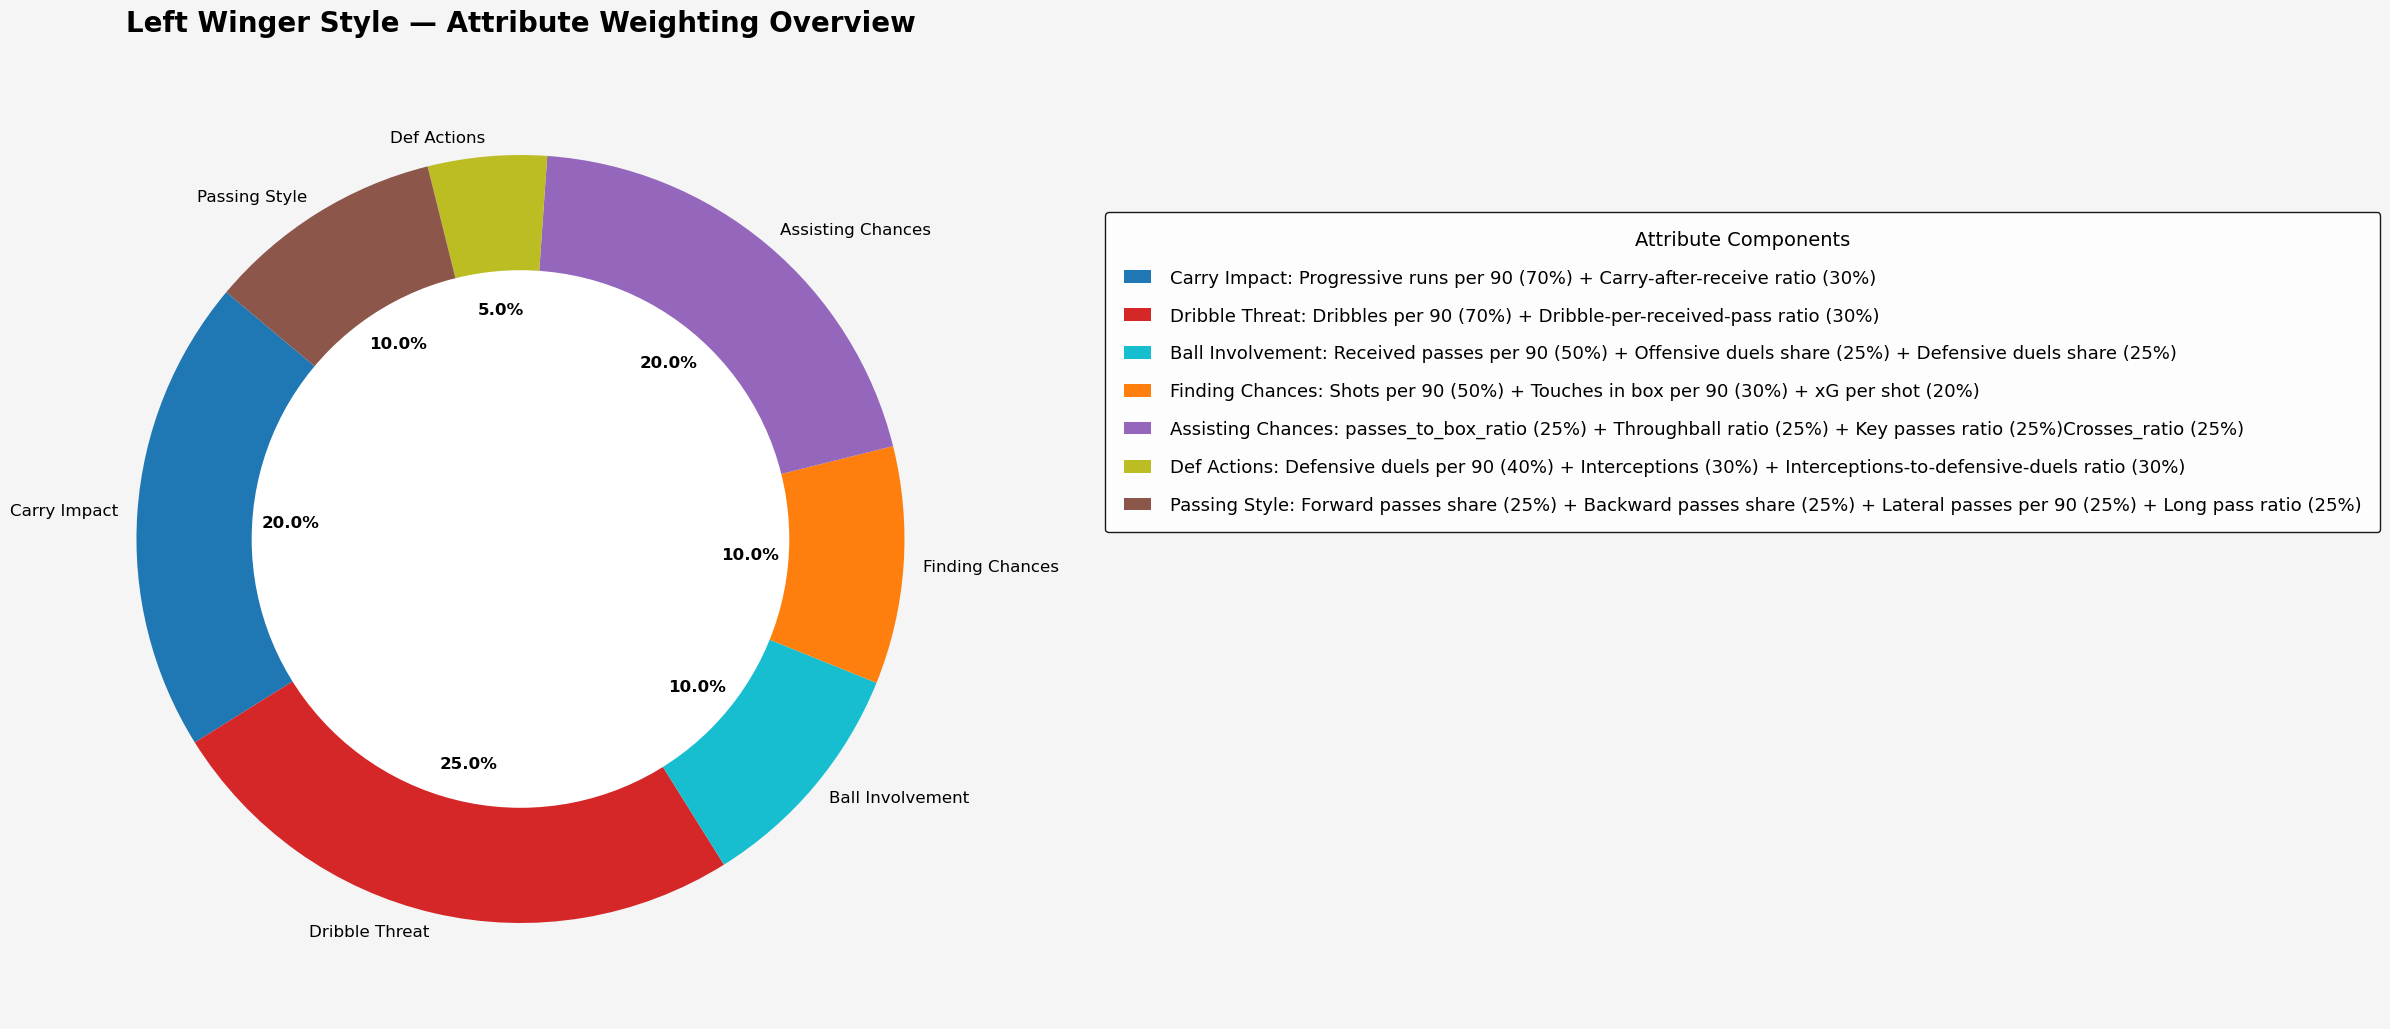

Saved weighting overview to C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\recruitment-case-viking\viz\weightings_main_attributes.jpg


In [87]:
import matplotlib.pyplot as plt

# hent vekter direkte fra modellen
style_weights = model.style_weights

weights = {
    'Carry Impact':      style_weights['carry_att'],            # 0.20
    'Dribble Threat':    style_weights['dribble_att'],          # 0.25
    'Ball Involvement':  style_weights['ball_involvement_att'], # 0.10
    'Finding Chances':   style_weights['finding_chances_att'],  # 0.10
    'Assisting Chances': style_weights['assisting_chances_att'],# 0.20
    'Def Actions':       style_weights['defensive_att'],        # 0.05
    'Passing Style':     style_weights['passing_style_att'],    # 0.10
}

# beskrivelser som matcher build_style_attributes i opprinnelig kode
descriptions = {
    'Carry Impact': (
        'Progressive runs per 90 (70%) + '
        'Carry-after-receive ratio (30%)'
    ),
    'Dribble Threat': (
        'Dribbles per 90 (70%) + '
        'Dribble-per-received-pass ratio (30%)'
    ),
    'Ball Involvement': (
        'Received passes per 90 (50%) + '
        'Offensive duels share (25%) + '
        'Defensive duels share (25%)'
    ),
    'Finding Chances': (
        'Shots per 90 (50%) + '
        'Touches in box per 90 (30%) + '
        'xG per shot (20%)'
    ),
    'Assisting Chances': (
        'passes_to_box_ratio (25%) + '
        'Throughball ratio (25%) + '
        'Key passes ratio (25%)'
        'Crosses_ratio (25%)'
    ),
    'Def Actions': (
        'Defensive duels per 90 (40%) + '
        'Interceptions (30%) + '
        'Interceptions-to-defensive-duels ratio (30%)'
    ),
    'Passing Style': (
        'Forward passes share (25%) + '
        'Backward passes share (25%) + '
        'Lateral passes per 90 (25%) + '
        'Long pass ratio (25%)'
    ),
}

# farger
color_map = {
    'Carry Impact': '#1f77b4',
    'Dribble Threat': '#d62728',
    'Ball Involvement': '#17becf',
    'Finding Chances': '#ff7f0e',
    'Assisting Chances': '#9467bd',
    'Def Actions': '#bcbd22',
    'Passing Style': '#8c564b',
}
colors = [color_map[key] for key in weights.keys()]

# figur
fig, ax = plt.subplots(figsize=(22, 12))
fig.patch.set_facecolor('whitesmoke')

wedges, texts, autotexts = ax.pie(
    weights.values(),
    labels=weights.keys(),
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    labeldistance=1.05,
    textprops={'fontsize': 12}
)

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

for text in texts:
    text.set_fontsize(12)

# donut
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

plt.title('Left Winger Style — Attribute Weighting Overview',
          fontsize=20, weight='bold', pad=20)

legend = plt.legend(
    wedges,
    [f"{k}: {v}" for k, v in descriptions.items()],
    title="Attribute Components",
    bbox_to_anchor=(1.1, 0.85),
    loc="upper left",
    fontsize=13,
    title_fontsize=14,
    frameon=True,
    framealpha=0.9,
    edgecolor='black',
    facecolor='white',
    borderpad=1.0,
    labelspacing=1.1,
    handlelength=1.5,
    handletextpad=1.1,
)
legend.get_frame().set_linewidth(1)

plt.tight_layout(rect=[0, 0, 0.65, 1])
plt.subplots_adjust(left=0.1, right=0.6, top=0.9, bottom=0.1)

out_path = VIZ_DIR / "weightings_main_attributes.jpg"
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved weighting overview to {out_path}")


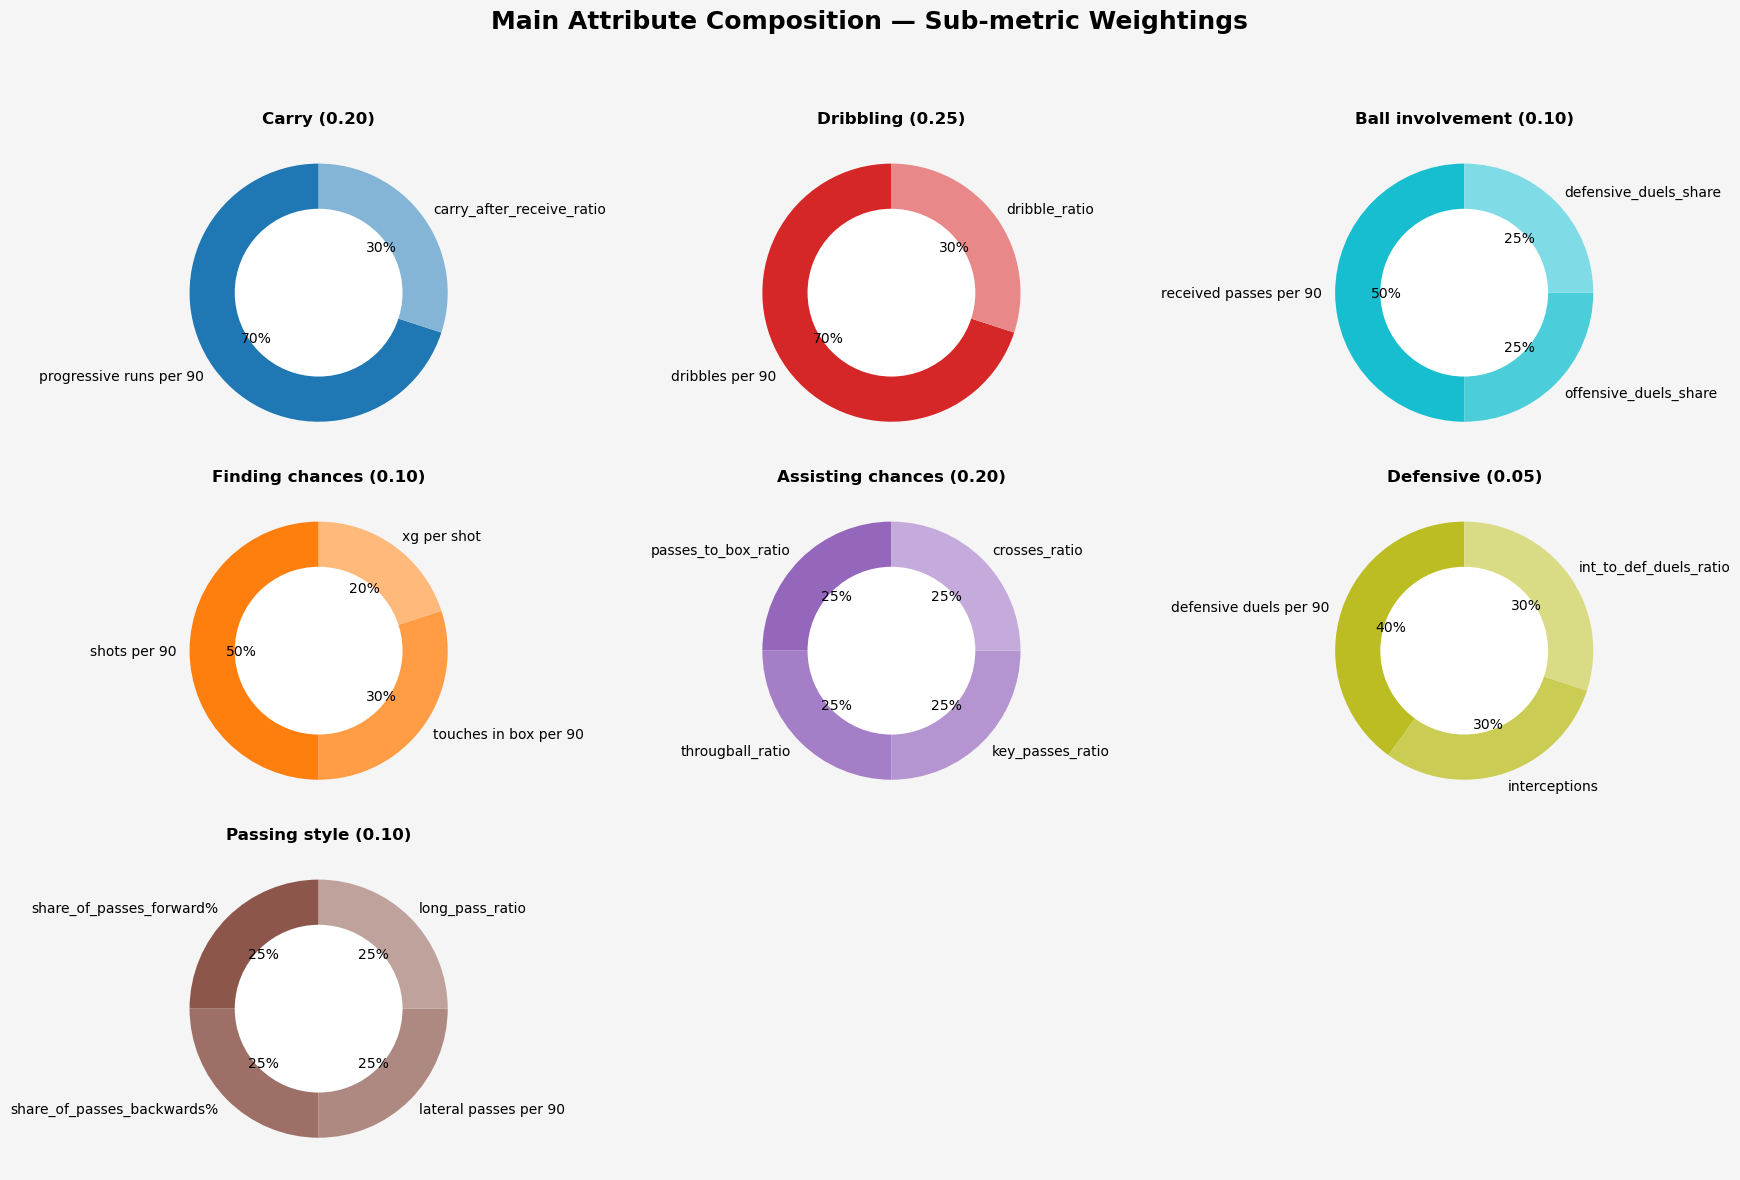

Saved weighting overview to C:\Users\henri\Desktop\Fotballanalyser\Ball\projects\recruitment-case-viking\viz\weightings_sub_attributes.jpg


In [89]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from typing import List

# direkte speil av build_style_attributes i StyleSimilarityModel 👇
attribute_details = {
    # carry_att = progressive runs per 90 * 0.7 + carry_after_receive_ratio * 0.3
    'Carry (0.20)': {
        'progressive runs per 90': 0.7,
        'carry_after_receive_ratio': 0.3,
    },

    # dribble_att = dribbles per 90 * 0.7 + dribble_ratio * 0.3
    'Dribbling (0.25)': {
        'dribbles per 90': 0.7,
        'dribble_ratio': 0.3,
    },

    'Ball involvement (0.10)': {
        'received passes per 90': 0.5,
        'offensive_duels_share': 0.25,
        'defensive_duels_share': 0.25,
    },

    # finding_chances_att = shots per 90 * 0.5
    #                       + touches in box per 90 * 0.3
    #                       + xg per shot * 0.2
    'Finding chances (0.10)': {
        'shots per 90': 0.50,
        'touches in box per 90': 0.30,
        'xg per shot': 0.20,
    },

    # assisting_chances_att = passes to penalty area per 90 * 0.35
    #                         + througball_ratio * 0.25
    #                         + key_passes_ratio * 0.40
    'Assisting chances (0.20)': {
        'passes_to_box_ratio': 0.25,
        'througball_ratio': 0.25,
        'key_passes_ratio': 0.25,
        'crosses_ratio':0.25,
    },

    # defensive_att = defensive duels per 90 * 0.4
    #                 + padj interceptions * 0.3
    #                 + int_to_def_duels_ratio * 0.3
    'Defensive (0.05)': {
        'defensive duels per 90': 0.40,
        'interceptions': 0.30,
        'int_to_def_duels_ratio': 0.30,
    },

    # passing_style_att = share_of_passes_forward% * 0.25
    #                     + share_of_passes_backwards% * 0.25
    #                     + lateral passes per 90 * 0.25
    #                     + long_pass_ratio * 0.25
    'Passing style (0.10)': {
        'share_of_passes_forward%': 0.25,
        'share_of_passes_backwards%': 0.25,
        'lateral passes per 90': 0.25,
        'long_pass_ratio': 0.25,
    },
}

# fargene kan vi gjenbruke, bare ett per hovedattributt
color_map = {
    'Carry (0.20)': '#1f77b4',
    'Dribbling (0.25)': '#d62728',
    'Ball involvement (0.10)': '#17becf',
    'Finding chances (0.10)': '#ff7f0e',
    'Assisting chances (0.20)': '#9467bd',
    'Defensive (0.05)': '#bcbd22',
    'Passing style (0.10)': '#8c564b',
}

def generate_shades(base_color: str, n: int) -> List[str]:
    base = mcolors.to_rgb(base_color)
    # lag en liten skala fra originalfarge → lysere
    shades = []
    for i in np.linspace(0, 0.45, n):
        shade = tuple((1 - i) * c + i * 1.0 for c in base)
        shades.append(mcolors.to_hex(shade))
    return shades

attributes = list(attribute_details.items())
cols = 3
rows = int(np.ceil(len(attributes) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
fig.patch.set_facecolor('whitesmoke')
axes = axes.flatten()

for idx, (attribute, metrics) in enumerate(attributes):
    ax = axes[idx]
    sizes = list(metrics.values())
    labels = list(metrics.keys())
    colors = generate_shades(color_map[attribute], len(labels))

    wedges, _, autotexts = ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct='%1.0f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )

    # hull i midten
    centre_circle = plt.Circle((0, 0), 0.65, fc='white')
    ax.add_artist(centre_circle)

    ax.set_title(attribute, fontsize=12, weight='bold')

# fjern ubrukte akser hvis det er færre attributter enn rader*kolonner
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Main Attribute Composition — Sub-metric Weightings', fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.94])

out_path = VIZ_DIR / "weightings_sub_attributes.jpg"
plt.savefig(out_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved weighting overview to {out_path}")

In [91]:
ratings.head()

,player,squad,club today,season,league,position,age,market value,contract months left,matches played,minutes played,birth country,passport country,foot,height,weight,on loan,duels per 90,"duels won, %",successful defensive actions per 90,defensive duels per 90,"defensive duels won, %",aerial duels per 90,"aerial duels won, %",padj sliding tackles,shots blocked per 90,padj interceptions,fouls per 90,yellow cards,yellow cards per 90,red cards per 90,non-penalty goals,non-penalty goals per 90,xg per 90,head goals,shots,shots per 90,"shots on target, %","goal conversion, %",assists per 90,"accurate crosses, %",crosses from left flank per 90,"accurate crosses from left flank, %",crosses from right flank per 90,"accurate crosses from right flank, %",crosses to goalie box per 90,dribbles per 90,"successful dribbles, %",offensive duels per 90,"offensive duels won, %",touches in box per 90,progressive runs per 90,accelerations per 90,received passes per 90,received long passes per 90,fouls suffered per 90,"accurate passes, %",forward passes per 90,"accurate forward passes, %",back passes per 90,"accurate back passes, %",lateral passes per 90,"accurate lateral passes, %",long passes per 90,"accurate long passes, %","average pass length, m","average long pass length, m",xa per 90,shot assists per 90,second assists per 90,third assists per 90,smart passes per 90,"accurate smart passes, %",key passes per 90,passes to final third per 90,"accurate passes to final third, %",passes to penalty area per 90,"accurate passes to penalty area, %",through passes per 90,"accurate through passes, %",deep completions per 90,deep completed crosses per 90,progressive passes per 90,"accurate progressive passes, %",season,xg per box touch,xg per shot,share_of_passes_forward%,share_of_passes_backwards%,carry_after_receive_ratio,througball_ratio,long_pass_ratio,dribble_ratio,o_u_performance_goals_xg,being_fouled_ratio,interceptions_to_duels_ratio,defensive_duels_share,offensive_duels_share,key_passes_ratio,assists_vs_shooting_balance,dribble_vs_assist_balance,dribble_vs_shooting_balance,passes_to_box_ratio,crosses_ratio,carry_att,dribble_att,ball_involvement_att,finding_chances_att,assisting_chances_att,defensive_att,passing_style_att,similarity_to_target
36,A. Smed,Hvidovre,Hvidovre,None,Denmark 1. div,"LWF, CF, LCMF",28,300000,0,18,1554,Denmark,Denmark,right,182,73,no,0.095649,0.609334,0.532864,0.300654,0.781215,0.224219,0.292667,0.544041,0.30,0.371642,0.241791,0.285714,0.214286,0.000000,0.133333,0.184615,0.200000,0.0,0.271930,0.352688,0.272692,0.090915,0.261364,0.2679,0.206452,0.2917,0.602606,0.2500,0.278261,0.049229,0.615438,0.046101,0.644669,0.398074,0.076446,0.060606,0.303738,0.435730,0.180203,0.470229,0.367783,0.612195,0.292286,0.624100,0.381370,0.492015,0.442718,0.3721,0.510703,0.741759,0.333333,0.214765,0.272727,0.000000,0.121212,0.5000,0.280822,0.349340,0.524541,0.344130,0.536539,0.108974,0.6667,0.229602,0.295620,0.433520,0.580019,None,0.133333,0.230769,0.486486,0.696970,0.057143,0.25,0.333333,0.053571,0.192308,0.458333,0.598039,0.558140,0.209677,0.166667,0.13125,0.052796,0.025000,0.36,0.344828,0.065450,0.054003,0.294696,0.366182,0.363728,0.495641,0.617077,0.676773
41,C. Tue Jensen,HB Køge,HB Køge,None,Denmark 1. div,"LWF, LW, LCMF",25,150000,0,18,1521,Denmark,Denmark,right,0,0,no,0.122841,0.432345,0.361502,0.334641,0.422327,0.212867,0.350933,0.067358,0.75,0.332836,0.247761,0.000000,0.000000,0.000000,0.266667,0.369231,0.400000,0.0,0.315789,0.425806,0.473644,0.197369,0.000000,0.5625,0.077419,0.5000,0.117264,0.6667,0.052174,0.051433,0.519211,0.117814,0.287614,0.181380,0.042355,0.060606,0.143302,0.150327,0.304569,0.586096,0.312356,0.598850,0.118188,0.662026,0.204932,0.751521,0.155340,0.6471,0.278287,0.398385,0.121212,0.043624,0.000000,0.631579,0.181818,0.6667,0.041096,0.292917,0.618145,0.186235,0.780494,0.076923,0.5000,0.134725,0.193431,0.326257,0.366740,None,0.466667,0.423077,0.621622,0.787879,0.085714,0.25,0.190476,0.089286,0.240385,0.541667,0.509804

In [93]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

class SimilarityTable:
    def __init__(
        self,
        df,
        style_cols,
        style_weights,
        target_player,
        max_age=None,
        max_value=None,
        min_minutes=None,
        exclude_teams=None,
        include_players=None,
        save_path=None,
    ):
        self.df = df.copy()
        self.style_cols = style_cols
        self.style_weights = style_weights
        self.target_player = target_player
        self.max_age = max_age
        self.max_value = max_value
        self.min_minutes = min_minutes
        self.exclude_teams = exclude_teams or []
        self.include_players = include_players or []
        self.save_path = save_path

        self.col_label_display_names = {
            "player": "Player",
            "squad": "Team",
            "league": "League",
            "age": "Age",
            "minutes played": "Minutes",
            "market value": "Value",
            "sim_carry_att": "Sim\nCarry",
            "sim_dribble_att": "Sim\nDribble",
            "sim_ball_involvement_att": "Sim\nBall\nInv.",
            "sim_finding_chances_att": "Sim\nFinding",
            "sim_assisting_chances_att": "Sim\nAssisting",
            "sim_defensive_att": "Sim\nDef.",
            "sim_passing_style_att": "Sim\nPassing",
            "similarity_to_target": "Total\nSimilarity",
        }

        self.desired_widths = {
            "Player": 0.16,
            "Team": 0.16,
            "League": 0.28,
            "Age": 0.06,
            "Minutes": 0.06,
            "Value": 0.07,
            "Sim\nCarry": 0.085,
            "Sim\nDribble": 0.085,
            "Sim\nBall\nInv.": 0.085,
            "Sim\nFinding": 0.085,
            "Sim\nAssisting": 0.085,
            "Sim\nDef.": 0.08,
            "Sim\nPassing": 0.085,
            "Total\nSimilarity": 0.10,
        }

    def generate_table(self, n_players=20):
        df = self.df.copy()

        # filtrering
        if self.exclude_teams:
            df = df[~df["squad"].isin(self.exclude_teams)]
        if self.max_age:
            df = df[df["age"] <= self.max_age]
        if self.max_value:
            df = df[df["market value"] <= self.max_value]
        if self.min_minutes:
            df = df[df["minutes played"] >= self.min_minutes]

        # alltid med target + include
        extra = self.df[self.df["player"].isin(self.include_players + [self.target_player])]
        df = pd.concat([df, extra]).drop_duplicates(subset=["player"])

        # hent target-vektor
        target_row = self.df[self.df["player"] == self.target_player]
        if target_row.empty:
            raise ValueError(f"Fant ikke spilleren {self.target_player}")
        target_vec = target_row[self.style_cols].mul(self.style_weights, axis=1).values  # (1, n)

        # cosine for total
        X = df[self.style_cols].mul(self.style_weights, axis=1).values
        cos_sims = cosine_similarity(target_vec, X)[0]
        df["similarity_to_target"] = cos_sims

        # per-attribute similarity (behold)
        target_vals = target_row[self.style_cols].iloc[0]
        for col in self.style_cols:
            sim_col = "sim_" + col
            df[sim_col] = 1 - (df[col] - target_vals[col]).abs()
            df[sim_col] = df[sim_col].clip(0, 1)

        # sorter etter cosine (samme som første kode)
        df = df.sort_values("similarity_to_target", ascending=False)
        df_top = df.head(n_players).copy()

        # kolonner
        base_cols = ["player", "squad", "league"]
        meta_cols = [c for c in ["age", "minutes played", "market value"] if c in df_top.columns]
        display_cols = base_cols + meta_cols + ["sim_" + c for c in self.style_cols] + ["similarity_to_target"]
        df_top = df_top[display_cols]

        # rund – men ikke for mye på sim
        for c in df_top.select_dtypes(include=np.number).columns:
            if c.startswith("Sim") or c == "similarity_to_target":
                df_top[c] = df_top[c].round(3)
            else:
                df_top[c] = df_top[c].round(2)

        # display names
        df_top.columns = [self.col_label_display_names.get(c, c) for c in df_top.columns]

        # plot
        row_height, header_height = 0.4, 0.3
        total_height = row_height * (len(df_top) + 1) + header_height
        dpi = 400
        fig_width_inch = 6600 / dpi

        fig, ax = plt.subplots(figsize=(fig_width_inch, total_height), dpi=dpi)
        ax.axis("off")

        col_widths = [self.desired_widths.get(c, 0.1) for c in df_top.columns]

        table = ax.table(
            cellText=df_top.values,
            colLabels=df_top.columns,
            colWidths=col_widths,
            cellLoc="center",
            loc="center",
        )

        for j in range(len(df_top.columns)):
            table[(0, j)].set_facecolor("#40466e")
            table[(0, j)].set_text_props(color="white", weight="bold", size=11)
            table[(0, j)].set_height(0.10)

        cmap = cm.get_cmap("RdYlGn")

        def lighten(color, factor=0.6):
            return tuple(1 - factor * (1 - c) for c in color)

        rating_cols = [c for c in df_top.columns if c.startswith("Sim") or c == "Total\nSimilarity"]

        for i in range(len(df_top)):
            for j, col in enumerate(df_top.columns):
                table[(i + 1, j)].set_height(0.095)
                if col in rating_cols:
                    val_norm = df_top.iloc[i][col]
                    val_norm = max(0, min(1, val_norm))
                    base_color = cmap(val_norm)
                    table[(i + 1, j)].set_facecolor(lighten(base_color))
                else:
                    table[(i + 1, j)].set_facecolor("white")
                table[(i + 1, j)].set_text_props(size=11, color="black")

        table.auto_set_font_size(False)
        table.scale(1, 1.5)
        out_path = VIZ_DIR / "sim_score.jpg"
        plt.savefig(out_path, dpi=300, bbox_inches='tight',transparent=True)
        plt.show()
        plt.close()

        return df_top


C:\Users\henri\AppData\Local\Temp\ipykernel_9312\3035089747.py:145: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("RdYlGn")


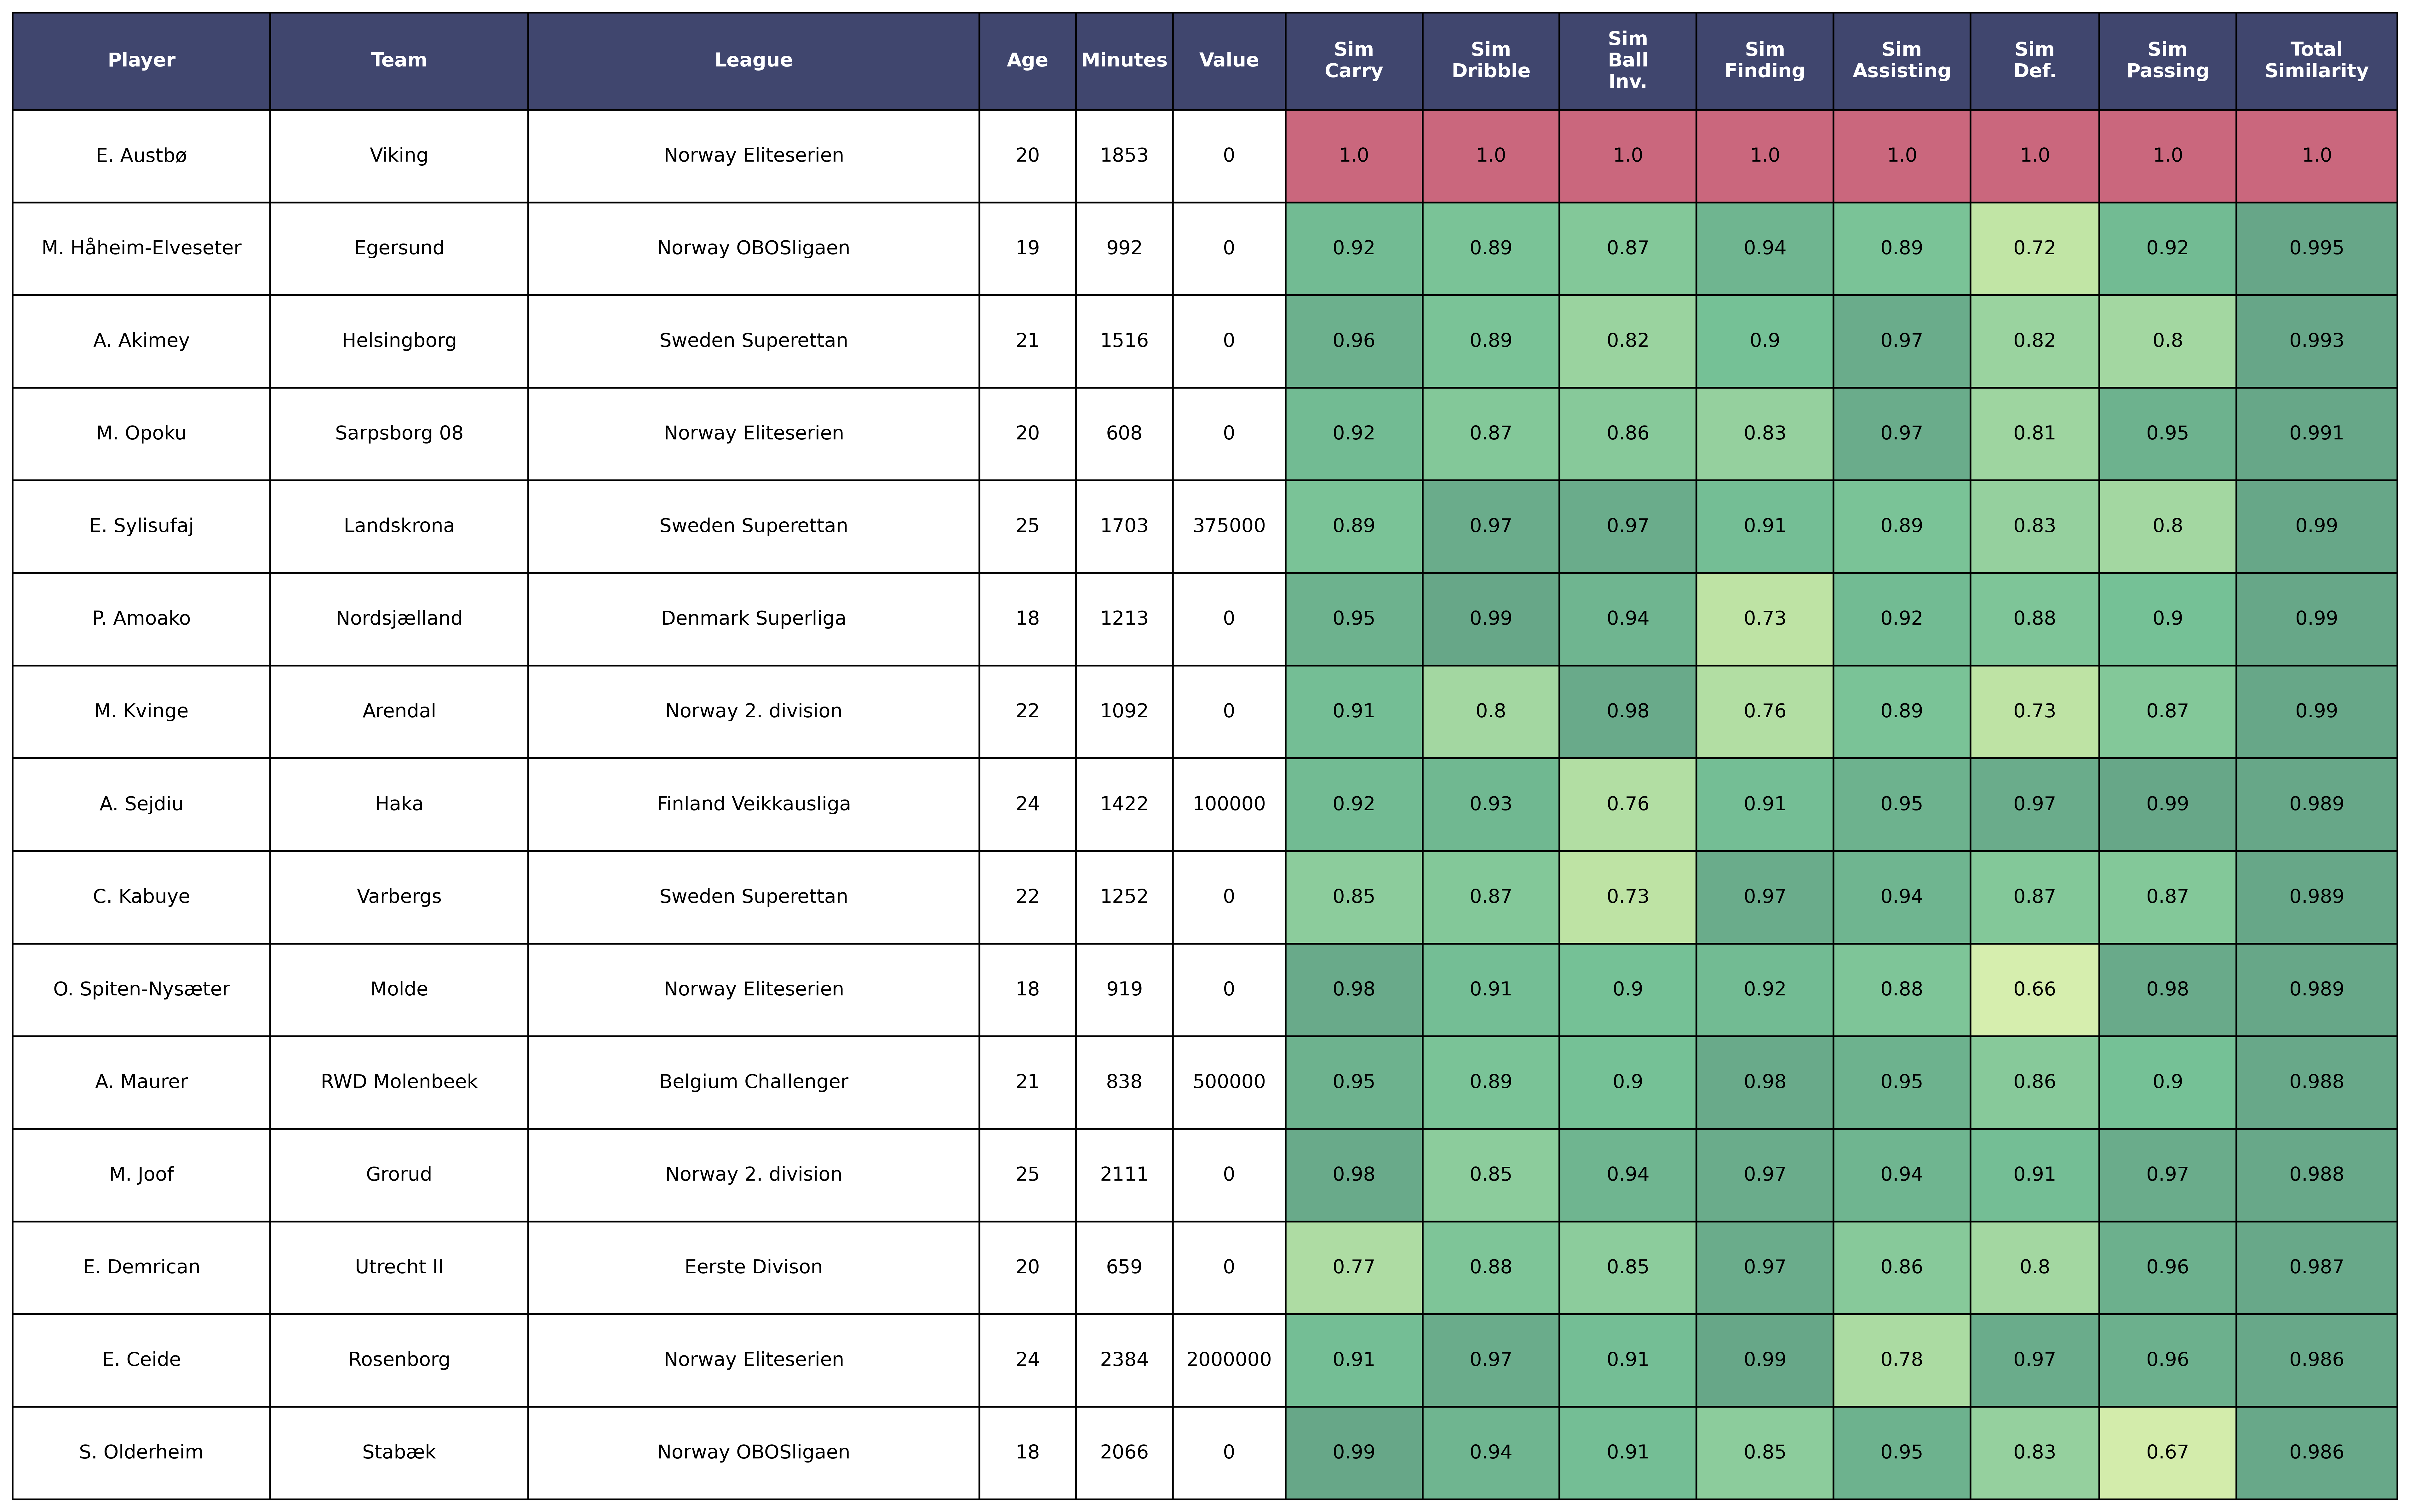

In [176]:
style_cols = [
    "carry_att",
    "dribble_att",
    "ball_involvement_att",
    "finding_chances_att",
    "assisting_chances_att",
    "defensive_att",
    "passing_style_att",
]

style_weights = {
    "carry_att": 0.20,
    "dribble_att": 0.25,
    "ball_involvement_att": 0.10,
    "finding_chances_att": 0.10,
    "assisting_chances_att": 0.20,
    "defensive_att": 0.05,
    "passing_style_att": 0.10,
}

table = SimilarityTable(
    df=ratings,
    style_cols=style_cols,
    style_weights=style_weights,
    target_player="E. Austbø",
    max_age=25,
    min_minutes=0,
    include_players=["E. Austbø"],
)

top_df = table.generate_table(n_players=15)


In [178]:
ratings.head()

,player,squad,club today,season,league,position,age,market value,contract months left,matches played,minutes played,birth country,passport country,foot,height,weight,on loan,duels per 90,"duels won, %",successful defensive actions per 90,defensive duels per 90,"defensive duels won, %",aerial duels per 90,"aerial duels won, %",padj sliding tackles,shots blocked per 90,padj interceptions,fouls per 90,yellow cards,yellow cards per 90,red cards per 90,non-penalty goals,non-penalty goals per 90,xg per 90,head goals,shots,shots per 90,"shots on target, %","goal conversion, %",assists per 90,"accurate crosses, %",crosses from left flank per 90,"accurate crosses from left flank, %",crosses from right flank per 90,"accurate crosses from right flank, %",crosses to goalie box per 90,dribbles per 90,"successful dribbles, %",offensive duels per 90,"offensive duels won, %",touches in box per 90,progressive runs per 90,accelerations per 90,received passes per 90,received long passes per 90,fouls suffered per 90,"accurate passes, %",forward passes per 90,"accurate forward passes, %",back passes per 90,"accurate back passes, %",lateral passes per 90,"accurate lateral passes, %",long passes per 90,"accurate long passes, %","average pass length, m","average long pass length, m",xa per 90,shot assists per 90,second assists per 90,third assists per 90,smart passes per 90,"accurate smart passes, %",key passes per 90,passes to final third per 90,"accurate passes to final third, %",passes to penalty area per 90,"accurate passes to penalty area, %",through passes per 90,"accurate through passes, %",deep completions per 90,deep completed crosses per 90,progressive passes per 90,"accurate progressive passes, %",season,xg per box touch,xg per shot,share_of_passes_forward%,share_of_passes_backwards%,carry_after_receive_ratio,througball_ratio,long_pass_ratio,dribble_ratio,o_u_performance_goals_xg,being_fouled_ratio,interceptions_to_duels_ratio,defensive_duels_share,offensive_duels_share,key_passes_ratio,assists_vs_shooting_balance,dribble_vs_assist_balance,dribble_vs_shooting_balance,passes_to_box_ratio,crosses_ratio,carry_att,dribble_att,ball_involvement_att,finding_chances_att,assisting_chances_att,defensive_att,passing_style_att,similarity_to_target
36,A. Smed,Hvidovre,Hvidovre,None,Denmark 1. div,"LWF, CF, LCMF",28,300000,0,18,1554,Denmark,Denmark,right,182,73,no,0.095649,0.609334,0.532864,0.300654,0.781215,0.224219,0.292667,0.544041,0.30,0.371642,0.241791,0.285714,0.214286,0.000000,0.133333,0.184615,0.200000,0.0,0.271930,0.352688,0.272692,0.090915,0.261364,0.2679,0.206452,0.2917,0.602606,0.2500,0.278261,0.049229,0.615438,0.046101,0.644669,0.398074,0.076446,0.060606,0.303738,0.435730,0.180203,0.470229,0.367783,0.612195,0.292286,0.624100,0.381370,0.492015,0.442718,0.3721,0.510703,0.741759,0.333333,0.214765,0.272727,0.000000,0.121212,0.5000,0.280822,0.349340,0.524541,0.344130,0.536539,0.108974,0.6667,0.229602,0.295620,0.433520,0.580019,None,0.133333,0.230769,0.486486,0.696970,0.057143,0.25,0.333333,0.053571,0.192308,0.458333,0.598039,0.558140,0.209677,0.166667,0.13125,0.052796,0.025000,0.36,0.344828,0.065450,0.054003,0.294696,0.366182,0.363728,0.495641,0.617077,0.676773
41,C. Tue Jensen,HB Køge,HB Køge,None,Denmark 1. div,"LWF, LW, LCMF",25,150000,0,18,1521,Denmark,Denmark,right,0,0,no,0.122841,0.432345,0.361502,0.334641,0.422327,0.212867,0.350933,0.067358,0.75,0.332836,0.247761,0.000000,0.000000,0.000000,0.266667,0.369231,0.400000,0.0,0.315789,0.425806,0.473644,0.197369,0.000000,0.5625,0.077419,0.5000,0.117264,0.6667,0.052174,0.051433,0.519211,0.117814,0.287614,0.181380,0.042355,0.060606,0.143302,0.150327,0.304569,0.586096,0.312356,0.598850,0.118188,0.662026,0.204932,0.751521,0.155340,0.6471,0.278287,0.398385,0.121212,0.043624,0.000000,0.631579,0.181818,0.6667,0.041096,0.292917,0.618145,0.186235,0.780494,0.076923,0.5000,0.134725,0.193431,0.326257,0.366740,None,0.466667,0.423077,0.621622,0.787879,0.085714,0.25,0.190476,0.089286,0.240385,0.541667,0.509804

In [99]:
col_list = df.columns.to_list()
print(col_list) #print the columns 

['player', 'squad', 'club today', 'season', 'league', 'position', 'age', 'market value', 'contract months left', 'matches played', 'minutes played', 'birth country', 'passport country', 'foot', 'height', 'weight', 'on loan', 'duels per 90', 'duels won, %', 'successful defensive actions per 90', 'defensive duels per 90', 'defensive duels won, %', 'aerial duels per 90', 'aerial duels won, %', 'padj sliding tackles', 'shots blocked per 90', 'padj interceptions', 'fouls per 90', 'yellow cards', 'yellow cards per 90', 'red cards per 90', 'non-penalty goals', 'non-penalty goals per 90', 'xg per 90', 'head goals', 'shots', 'shots per 90', 'shots on target, %', 'goal conversion, %', 'assists per 90', 'accurate crosses, %', 'crosses from left flank per 90', 'accurate crosses from left flank, %', 'crosses from right flank per 90', 'accurate crosses from right flank, %', 'crosses to goalie box per 90', 'dribbles per 90', 'successful dribbles, %', 'offensive duels per 90', 'offensive duels won, %'

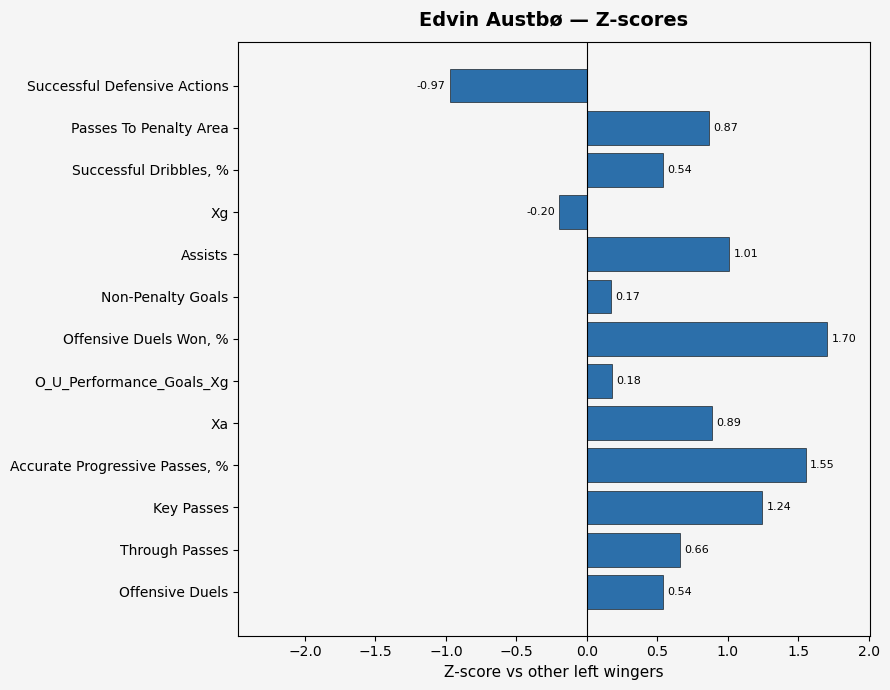

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) features du vil se på
features = [
            "offensive duels per 90",
            "through passes per 90",
            "key passes per 90",
            "accurate progressive passes, %",
            "xa per 90",
            "o_u_performance_goals_xg",
            "offensive duels won, %",
            "non-penalty goals per 90",
            "assists per 90",
            "xg per 90",
            "successful dribbles, %",
            "passes to penalty area per 90",
            "successful defensive actions per 90",
]

# 2) Opprett kopi for z-score beregninger
z_performance_df = df.copy()

# z-score per kolonne på z_performance_df
for col in features:
    col_mean = z_performance_df[col].mean()
    col_std = z_performance_df[col].std()
    if col_std == 0 or np.isnan(col_std):
        z_performance_df[col + '_z'] = 0
    else:
        z_performance_df[col + '_z'] = (z_performance_df[col] - col_mean) / col_std

# 3) hent Lamine Yamal fra z_performance_df
target_row = z_performance_df[z_performance_df['player'] == 'E. Austbø']
if target_row.empty:
    raise ValueError("Fant ikke E. Austbø i filtered_df")

target_z = [target_row[f + '_z'].iloc[0] for f in features]
labels = [f.replace('raw_', '').replace(' per 90', '').title() for f in features]

# 4) plot
fig, ax = plt.subplots(figsize=(9, 7))

# bakgrunn
fig.patch.set_facecolor('whitesmoke')
ax.set_facecolor('whitesmoke')

bars = ax.barh(
    range(len(features)),
    target_z,
    color='#2c6faa',    # litt dypere blå
    edgecolor='black',
    linewidth=0.4
)

# akse og tittel
ax.set_yticks(range(len(features)))
ax.set_yticklabels(labels, fontsize=10)
ax.set_xlabel('Z-score vs other left wingers', fontsize=11)
ax.set_title('Edvin Austbø — Z-scores', fontsize=14, weight='bold', pad=12)

# vertikal nullinje
ax.axvline(0, color='black', linewidth=0.8)

# legg på tall på stengene
for i, v in enumerate(target_z):
    ax.text(
        v + (0.03 if v >= 0 else -0.03),
        i,
        f"{v:.2f}",
        va='center',
        ha='left' if v >= 0 else 'right',
        fontsize=8,
        color='black'
    )

# litt margin på x
xmin = min(target_z) - 1.5
xmax = max(target_z) + 0.3
ax.set_xlim(xmin, xmax)

plt.tight_layout()

# 5) lagre
out_path = VIZ_DIR / "perf_score.jpg"
plt.savefig(out_path, dpi=300, bbox_inches='tight',transparent=True)
plt.show()
plt.close()

In [109]:
col_list = df.columns.to_list()
print(col_list) #print the columns 

['player', 'squad', 'club today', 'season', 'league', 'position', 'age', 'market value', 'contract months left', 'matches played', 'minutes played', 'birth country', 'passport country', 'foot', 'height', 'weight', 'on loan', 'duels per 90', 'duels won, %', 'successful defensive actions per 90', 'defensive duels per 90', 'defensive duels won, %', 'aerial duels per 90', 'aerial duels won, %', 'padj sliding tackles', 'shots blocked per 90', 'padj interceptions', 'fouls per 90', 'yellow cards', 'yellow cards per 90', 'red cards per 90', 'non-penalty goals', 'non-penalty goals per 90', 'xg per 90', 'head goals', 'shots', 'shots per 90', 'shots on target, %', 'goal conversion, %', 'assists per 90', 'accurate crosses, %', 'crosses from left flank per 90', 'accurate crosses from left flank, %', 'crosses from right flank per 90', 'accurate crosses from right flank, %', 'crosses to goalie box per 90', 'dribbles per 90', 'successful dribbles, %', 'offensive duels per 90', 'offensive duels won, %'

In [113]:
df.league.unique()

array(['Denmark 1. div', 'Denmark Superliga', 'Finland Veikkausliga',
       'Iceland Bestadeltid', 'Iceland 1. div', 'Norway 2. division',
       'Norway Eliteserien', 'Norway OBOSligaen', 'Sweden Allsvenskan',
       'Sweden Superettan', 'Slovakia', 'Slovenia', 'Belgium Challenger',
       '2. Bundesliga', 'Czech Chance League', 'Eerste Divison',
       'Ligue 2'], dtype=object)

In [186]:
from typing import Dict, List, Optional
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


class PerformanceRanker:
    """
    Beregner liga-justert performance-score og slår sammen med similarity.
    """

    def __init__(
        self,
        performance_features: Optional[List[str]] = None,
        league_adjustments: Optional[Dict[str, float]] = None,
    ) -> None:

        self.performance_features = performance_features or [
            "offensive duels per 90",
            "through passes per 90",
            "key passes per 90",
            "accurate progressive passes, %",
            "xa per 90",
            "offensive duels won, %",
            "non-penalty goals per 90",
            "assists per 90",
            "xg per 90",
            "successful dribbles, %",
            "passes to penalty area per 90",
            "successful defensive actions per 90",
        ]

        self.league_adjustments = league_adjustments or {
            "Denmark 1. div": -0.156,
            "Denmark Superliga": 0.212,
            "Finland Veikkausliga": -0.334,
            "Iceland Besta Deltid": -0.49,
            "Iceland 1. div": -0.491,
            "Norway 2. division": -0.509, #manually changed from -0.409 to -0.509
            "Norway Eliteserien": 0.012,
            "Norway OBOSligaen": -0.327,
            "Sweden Allsvenskan": 0.0,
            "Sweden Superettan": -0.406,
            "Slovakia": -0.318,
            "Slovenia": -0.188,
            "Belgium Challenger": -0.026,
            "2. Bundesliga": 0.191,
            "Czech Chance League": -0.002,
            "Eerste Divison": -0.107,
            "Ligue 2": 0.127,
        }

    # ---------------- Helpers ----------------

    def _check_columns_exist(self, df: pd.DataFrame) -> None:
        missing = [c for c in self.performance_features if c not in df.columns]
        if missing:
            raise KeyError(f"Disse performance-kolonnene mangler i df: {missing}")

    # ---------------- Main API ----------------

    def compute_performance(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        self._check_columns_exist(df)

        scaler = StandardScaler()
        perf_array = scaler.fit_transform(df[self.performance_features])

        df["performance_score_components"] = perf_array.mean(axis=1)
        df["performance_score_z"] = StandardScaler().fit_transform(
            df[["performance_score_components"]]
        )

        df["performance_score_adjusted"] = (
            df["performance_score_z"] +
            df["league"].map(self.league_adjustments).fillna(0.0)
        )

        perf_min = df["performance_score_adjusted"].min()
        perf_max = df["performance_score_adjusted"].max()

        if np.isclose(perf_min, perf_max):
            df["performance_score"] = 0.5
        else:
            df["performance_score"] = (
                df["performance_score_adjusted"] - perf_min
            ) / (perf_max - perf_min)

        return df

    def merge_with_similarity(
        self,
        perf_df: pd.DataFrame,
        ratings: pd.DataFrame,
        similarity_threshold: float = 0.85,
    ) -> pd.DataFrame:
        """
        Slår sammen performance og similarity, og filtrerer på min similarity.
        """

        perf_df = perf_df.copy()
        ratings = ratings.copy()

        sim_cols = ["player", "squad", "league", "similarity_to_target"]
        similarity_df = ratings[sim_cols].drop_duplicates(
            subset=["player", "squad", "league"]
        )

        merged_scores = similarity_df.merge(
            perf_df[
                [
                    "player",
                    "squad",
                    "league",
                    "performance_score_z",
                    "performance_score_adjusted",
                    "performance_score",
                ]
            ],
            on=["player", "squad", "league"],
            how="left",
        )

        # Rund av for lesbarhet
        merged_scores["similarity_to_target"] = merged_scores["similarity_to_target"].round(4)
        merged_scores["performance_score_adjusted"] = merged_scores["performance_score_adjusted"].round(3)
        merged_scores["performance_score"] = merged_scores["performance_score"].round(2)

        # 🔥 FILTER HERE — minimum similarity
        merged_scores = merged_scores[merged_scores["similarity_to_target"] >= similarity_threshold]

        return merged_scores


In [188]:
ranker = PerformanceRanker()

# 1) performance på hele datasetet
df_with_perf = ranker.compute_performance(df)

# 2) merge med similarity og filtrer for similarity ≥ 0.85
merged_scores = ranker.merge_with_similarity(
    perf_df=df_with_perf,
    ratings=ratings,
    similarity_threshold=0.85
)

print(merged_scores)


              player          squad          league  similarity_to_target  \
2         J. Wielzen     Middelfart  Denmark 1. div                0.9520   
4       V. Rasmussen          Hobro  Denmark 1. div                0.9550   
5        M. Kaastrup  Aarhus Fremad  Denmark 1. div                0.9791   
6      K. Grabovskis           B.93  Denmark 1. div                0.8705   
7          S. Jalaei       Hillerød  Denmark 1. div                0.9643   
..               ...            ...             ...                   ...   
242       A. Boutrah         Bastia         Ligue 2                0.9361   
243        A. Hbouch         Annecy         Ligue 2                0.9741   
244  Z. Davitashvili  Saint-Étienne         Ligue 2                0.8937   
245    A. El Farissi       Boulogne         Ligue 2                0.9080   
247      K. Nakamura          Reims         Ligue 2                0.9394   

     performance_score_z  performance_score_adjusted  performance_score  
2

In [190]:
merged_scores.head(30)

,player,squad,league,similarity_to_target,performance_score_z,performance_score_adjusted,performance_score
2,J. Wielzen,Middelfart,Denmark 1. div,0.9520,-0.797863,-0.954,0.27
4,V. Rasmussen,Hobro,Denmark 1. div,0.9550,-0.670095,-0.826,0.29
5,M. Kaastrup,Aarhus Fremad,Denmark 1. div,0.9791,0.302570,0.147,0.45
6,K. Grabovskis,B.93,Denmark 1. div,0.8705,-0.006753,-0.163,0.40
7,S. Jalaei,Hillerød,Denmark 1. div,0.9643,-0.426998,-0.583,0.33
8,S. Colyn,Lyngby,Denmark 1. div,0.9130,1.311138,1.155,0.61
10,K. Hansen,AaB,Denmark 1. div,0.9449,-0.113510,-0.270,0.38
11,O. Addo,B.93,Denmark 1. div,0.9743,-0.222017,-0.378,0.37
12,K. Arnstad,AGF,Denmark Superliga,0.8501,0.385156,0.597,0.52
15,P. Amoako,Nordsjælland,Denmark Superliga,0.9896,1.112046,1.324,0.64


In [324]:
best_performance=merged_scores[['player', 'squad','performance_score_z', 'performance_score_adjusted', 'performance_score']]

In [326]:
best_performance = best_performance.sort_values('performance_score', ascending=False).head(15)
display(best_performance)

,player,squad,performance_score_z,performance_score_adjusted,performance_score
18,A. Şimşir,Midtjylland,3.369043,3.581,1.00
42,A. Sigurdarson,KR,3.013624,2.524,0.83
106,S. Ørjasæter,Sarpsborg 08,2.462714,2.475,0.82
183,A. Ramadan,DAC,2.636390,2.318,0.80
227,I. El Kadiri,De Graafschap,2.258865,2.152,0.77
22,A. Muçolli,Fredericia,1.939908,2.152,0.77
64,E. Hjertager,Sandnes Ulf,2.465673,1.957,0.74
98,E. Ceide,Rosenborg,1.961718,1.974,0.74
38,H. Steingrimsson,KA,2.249422,1.759,0.71
127,Félix Vá,Lillestrøm,2.055632,1.729,0.70


In [198]:
merged_scores.columns

Index(['player', 'squad', 'league', 'similarity_to_target',
       'performance_score_z', 'performance_score_adjusted',
       'performance_score'],
      dtype='object')

In [318]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Optional, List, Tuple


from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Optional, List, Tuple


class SimilarityPerformancePlot:
    """
    Plotter similarity (x) vs liga-justert performance (y),
    med farge = alder og labels på utvalgte spillere.
    """

    def __init__(
        self,
        merged_scores: pd.DataFrame,
        df: pd.DataFrame,
        similarity_threshold: float = 0.85,
        figsize: Tuple[float, float] = (12, 9),
    ) -> None:
        self.merged_scores = merged_scores.copy()
        self.df = df.copy()
        self.similarity_threshold = similarity_threshold
        self.figsize = figsize

        self.style_config = {
            "figure_facecolor": "whitesmoke",
            "axes_facecolor": "white",
            "scatter_cmap": "RdYlGn_r",  # grønn = ung, rød = gammel
            "scatter_size": 70,
            "scatter_alpha": 0.9,
            "scatter_edgecolor": "black",
            "scatter_linewidth": 0.8,
            "fontsize_labels": 12,
            "fontsize_title": 14,
            "fontsize_annotations": 7,
            "grid_alpha": 0.3,
            "colorbar_size": "3%",
            "colorbar_pad": 0.08,
            "arrow_alpha": 0.4,
            "arrow_linewidth": 0.6,
        }

    # ---------------- Data ----------------
    def _prepare_data(self) -> pd.DataFrame:
        """
        Filtrer på similarity-threshold og legg til alder.
        """
        plot_df = (
            self.merged_scores[
                self.merged_scores["similarity_to_target"] >= self.similarity_threshold
            ]
            .dropna(subset=["performance_score_adjusted"])
            .copy()
        )

        # unik alder per spiller
        age_lookup = (
            self.df[["player", "age"]]
            .dropna(subset=["age"])
            .drop_duplicates(subset=["player"])
            .set_index("player")["age"]
        )
        plot_df["age"] = plot_df["player"].map(age_lookup)

        # Sørg for at target er med (E. Austbø)
        if "E. Austbø" not in plot_df["player"].values:
            target_data = self.df[self.df["player"] == "E. Austbø"]
            if not target_data.empty:
                target_row = pd.DataFrame(
                    {
                        "player": ["E. Austbø"],
                        "squad": [target_data["squad"].iloc[0]],
                        "league": [target_data["league"].iloc[0]],
                        "similarity_to_target": [1.0],
                        "performance_score_adjusted": [
                            target_data["performance_score_adjusted"].iloc[0]
                        ],
                        "performance_score": [target_data["performance_score"].iloc[0]],
                        "age": [target_data["age"].iloc[0]],
                    }
                )
                plot_df = pd.concat([plot_df, target_row], ignore_index=True)

        return plot_df

# ---------------- Label-offset ----------------
    def _calculate_dynamic_offsets(self, candidates: pd.DataFrame) -> List[Tuple[float, float]]:
        """
        Små base-offsets, labels holdes nær punktene.
        """
        offsets: List[Tuple[float, float]] = []
        for _, row in candidates.iterrows():
            similarity = row["similarity_to_target"]

            # litt større offset i den mest tette similarity-sonen
            if 0.975 <= similarity <= 0.985:
                base_offset = 0.007
            else:
                base_offset = 0.005  # mye mindre enn 0.05

            angle = np.random.uniform(0, 2 * np.pi)
            dx = base_offset * np.cos(angle)
            dy = base_offset * np.sin(angle)
            offsets.append((dx, dy))

        return offsets

    def _optimize_label_positions(
        self,
        candidates: pd.DataFrame,
        offsets: List[Tuple[float, float]],
        max_offset: float = 0.015,  # låser maks-avstand til ca 0.015
    ) -> List[Tuple[float, float]]:
        """
        Unngå overlapp mellom:
        - label ↔ eget punkt
        - label ↔ andre labels
        med små iterativ nudging og begrenset pil-lengde.
        """
        optimized = offsets.copy()
        min_dist_point = 0.010
        min_dist_label = 0.015

        def cap_offset(i: int) -> None:
            dx, dy = optimized[i]
            r = float(np.hypot(dx, dy))
            if r > max_offset and r > 0:
                scale = max_offset / r
                optimized[i] = (dx * scale, dy * scale)

        def get_positions():
            pos = []
            for idx, (_, row) in enumerate(candidates.iterrows()):
                dx, dy = optimized[idx]
                pos.append(
                    (
                        row["similarity_to_target"] + dx,
                        row["performance_score_adjusted"] + dy,
                    )
                )
            return pos

        for _ in range(20):  # maks 20 iterasjoner
            positions = get_positions()
            moved = False

            for i, (_, row_i) in enumerate(candidates.iterrows()):
                xi, yi = positions[i]
                dxi, dyi = optimized[i]

                # label vs eget punkt
                dist_p = np.hypot(
                    xi - row_i["similarity_to_target"],
                    yi - row_i["performance_score_adjusted"],
                )
                if dist_p < min_dist_point:
                    optimized[i] = (dxi * 1.03, dyi * 1.03)
                    cap_offset(i)
                    moved = True

                # label vs andre labels
                for j in range(i + 1, len(positions)):
                    xj, yj = positions[j]
                    dist_ll = np.hypot(xi - xj, yi - yj)

                    if dist_ll < min_dist_label:
                        ox_i, oy_i = optimized[i]
                        ox_j, oy_j = optimized[j]
                        optimized[i] = (ox_i * 1.02, oy_i * 1.02)
                        optimized[j] = (ox_j * 1.02, oy_j * 1.02)
                        cap_offset(i)
                        cap_offset(j)
                        moved = True

            if not moved:
                break

        return optimized


    # ---------------- Plot ----------------
    def _create_plot(self, plot_df: pd.DataFrame) -> Tuple[plt.Figure, plt.Axes]:
        fig, ax = plt.subplots(figsize=self.figsize)
        fig.patch.set_facecolor(self.style_config["figure_facecolor"])
        ax.set_facecolor(self.style_config["axes_facecolor"])

        scatter = ax.scatter(
            plot_df["similarity_to_target"],
            plot_df["performance_score_adjusted"],
            c=plot_df["age"],
            cmap=self.style_config["scatter_cmap"],
            s=self.style_config["scatter_size"],
            alpha=self.style_config["scatter_alpha"],
            edgecolor=self.style_config["scatter_edgecolor"],
            linewidth=self.style_config["scatter_linewidth"],
        )

        return fig, ax, scatter

    def _configure_axes(self, ax: plt.Axes, plot_df: pd.DataFrame) -> None:
        ax.set_xlabel(
            "Similarity to Austbø (cosine)",
            fontsize=self.style_config["fontsize_labels"],
        )
        ax.set_ylabel(
            "Performance Score",
            fontsize=self.style_config["fontsize_labels"],
        )
        ax.set_title(
            "Left Winger Fit Landscape — Similarity vs Performance",
            fontsize=self.style_config["fontsize_title"],
            pad=20,
        )

        # y-max skal være 4.05
        y_min = -2.0
        y_max = plot_df["performance_score_adjusted"].max()
        y_margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - y_margin, 4.05)

        ax.set_xlim(0.85, 1.02)
        ax.grid(True, alpha=self.style_config["grid_alpha"],
                linestyle="--", linewidth=0.5)

    def _add_annotations(self, ax: plt.Axes, plot_df: pd.DataFrame) -> None:
        # topp 15 på performance (skalert [0,1])
        top_perf = (
            plot_df.sort_values("performance_score", ascending=False)
            .head(15)
        )

        high_both = plot_df[
            (plot_df["similarity_to_target"] > 0.995)
            & (plot_df["performance_score"] > 0.65)
        ]

        very_high_perf = plot_df[
            plot_df["performance_score_adjusted"] > 1.2
        ]

        austbo = plot_df[plot_df["player"] == "E. Austbø"]

        candidates = (
            pd.concat([top_perf, high_both, very_high_perf, austbo], ignore_index=True)
            .drop_duplicates(subset=["player", "squad", "league"])
            .reset_index(drop=True)
        )

        if candidates.empty:
            return

        initial_offsets = self._calculate_dynamic_offsets(candidates)
        optimized_offsets = self._optimize_label_positions(candidates, initial_offsets)

        # Overstyr offsets for "klumpen"
        cluster_mask = (
            (candidates["similarity_to_target"].between(0.98, 0.995))
            & (candidates["performance_score_adjusted"].between(1.0, 1.3))
        )
        cluster_indices = candidates[cluster_mask].index.to_list()

        base = 0.008  # liten, kontrollert avstand
        directions = [
            ( 1.0,  0.4),
            (-1.0,  0.4),
            ( 1.0, -0.4),
            (-1.0, -0.4),
            ( 0.5,  1.0),
            (-0.5,  1.0),
            ( 0.5, -1.0),
            (-0.5, -1.0),
        ]

        for k, idx in enumerate(cluster_indices):
            dx_dir, dy_dir = directions[k % len(directions)]
            optimized_offsets[idx] = (base * dx_dir, base * dy_dir)

        # Annoter alle labels
        NO_ARROW_THRESH = 0.01  # alles under dette får ingen pil

        for i, (_, row) in enumerate(candidates.iterrows()):
            dx, dy = optimized_offsets[i]
            offset_length = float(np.hypot(dx, dy))

            last_name = row["player"].split()[-1]
            squad = row.get("squad", "")
            squad_str = str(squad) if pd.notna(squad) else ""
            label_text = f"{last_name} ({squad_str})" if squad_str else last_name

            x = row["similarity_to_target"]
            y = row["performance_score_adjusted"]

            # ---- Spesial-case: E. Austbø → kort pil + bold ----
            if row["player"] == "E. Austbø":
                ax.annotate(
                    label_text,
                    xy=(x, y),
                    xytext=(x + 0.01, y + 0.015),
                    fontsize=self.style_config["fontsize_annotations"],
                    color="black",
                    fontweight="bold",
                    arrowprops=dict(
                        arrowstyle="->",
                        lw=self.style_config["arrow_linewidth"],
                        color="black",
                        alpha=self.style_config["arrow_alpha"],
                        connectionstyle="arc3,rad=0.1",
                        shrinkA=0,
                        shrinkB=5,
                    ),
                )
                continue

            # ---- CASE 1: ingen pil → label rett over punktet ----
            if offset_length < NO_ARROW_THRESH:
                ax.annotate(
                    label_text,
                    xy=(x, y),
                    xytext=(0, 8),          # 14 points rett opp
                    textcoords="offset points",
                    fontsize=self.style_config["fontsize_annotations"],
                    color="black",
                    verticalalignment="bottom",
                    horizontalalignment="center",
                )
            # ---- CASE 2: normal offset → pil + kort tekstoffset ----
            else:
                label_scale = 0.8
                tx = x + dx * label_scale
                ty = y + dy * label_scale

                ax.annotate(
                    label_text,
                    xy=(x, y),
                    xytext=(tx, ty),
                    fontsize=self.style_config["fontsize_annotations"],
                    color="black",
                    arrowprops=dict(
                        arrowstyle="->",
                        lw=self.style_config["arrow_linewidth"],
                        color="black",
                        alpha=self.style_config["arrow_alpha"],
                        connectionstyle="arc3,rad=0.1",
                        shrinkA=0,
                        shrinkB=5,
                    ),
                )


    def _add_colorbar(self, fig: plt.Figure, ax: plt.Axes, scatter: plt.Axes) -> None:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(
            "right",
            size=self.style_config["colorbar_size"],
            pad=self.style_config["colorbar_pad"],
        )
        cbar = fig.colorbar(scatter, cax=cax)
        cbar.set_label("Age (younger → older)", fontsize=9, labelpad=8)
        cbar.ax.tick_params(labelsize=7)

    def _add_info_text(self, ax: plt.Axes) -> None:
        ax.text(
            0.02,
            0.98,
            "• Color = Age\n• Green = younger, \n•Red = older",
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )

    def plot(self, save_path: Optional[str] = None) -> Tuple[plt.Figure, plt.Axes]:
        plot_df = self._prepare_data()
        fig, ax, scatter = self._create_plot(plot_df)
        self._configure_axes(ax, plot_df)
        self._add_annotations(ax, plot_df)
        self._add_colorbar(fig, ax, scatter)
        self._add_info_text(ax)

        plt.tight_layout()

        if save_path:
            plt.savefig(
                save_path,
                dpi=400,
                bbox_inches="tight",
                facecolor=self.style_config["figure_facecolor"],
            )

        plt.show()
        return fig, ax



def create_similarity_performance_plot(
    merged_scores: pd.DataFrame,
    df: pd.DataFrame,
    similarity_threshold: float = 0.85,
    figsize: Tuple[float, float] = (14, 10),
    save_path: Optional[str] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    plotter = SimilarityPerformancePlot(
        merged_scores=merged_scores,
        df=df,
        similarity_threshold=similarity_threshold,
        figsize=figsize,
    )
    return plotter.plot(save_path=save_path)

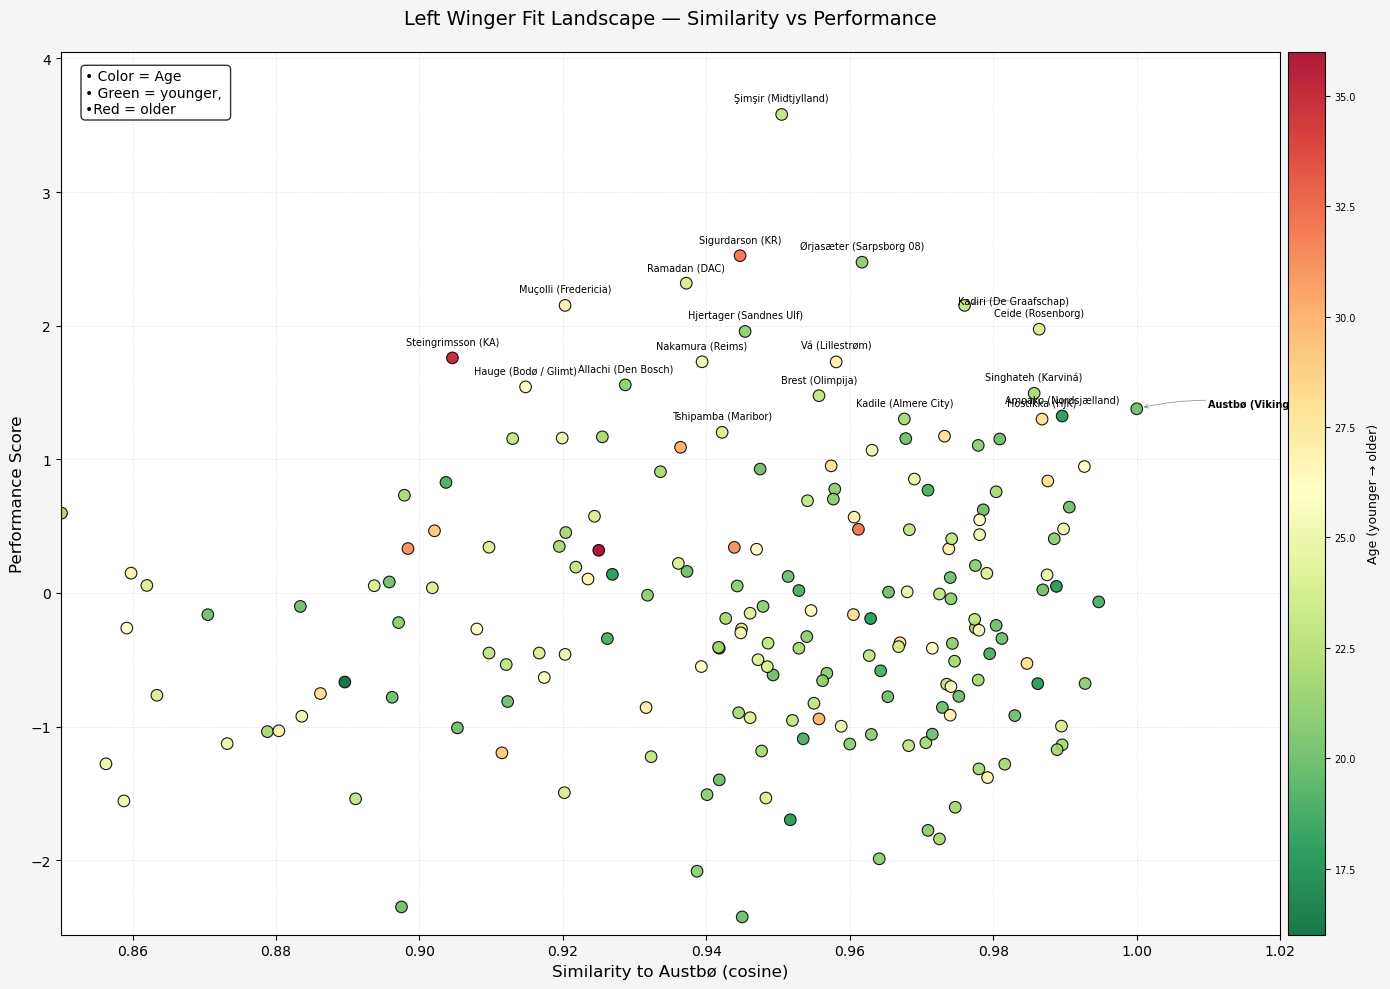

In [320]:
fig, ax = create_similarity_performance_plot(
    merged_scores=merged_scores,
    df=df,
    save_path=VIZ_DIR / "perf_sim_score.jpg"
)
